# Amazon rainforest 

**Objective**

The **goal** of this study is to understand **which factors** potentially have impact on **deforestation**. Here, it's going to be examined deforestation **throughout the years 2008 to 2019**. To make sense of the data, **three sources** are going to be considered: 

- **Rural Industry**: the **Agriculture** (acres) and **Cattle** farming (bovine head) data **from 2008 to 2019 per Countie**
- **Social & Economic**: Human Development Index metrics — **HDI**, **Income HDI**, **Education HDI**, **Longevity HDI**; estimated **GDP** per Countie **from 2008 to 2019**
- **Legal protected areas**: spatial data with **indigenous areas** to show if the **deforestation is happening in protected regions**  

**Methodology**

Train **classification** Machine Learning **algorithms** — **Random Forest**, **Extremely Randomized Trees**, **XGBoost** and **CatBoost** — to show which factors are more relevant in predicting **high deforestation** in this period of time  

- The **ground for the analysis** and Machine Learning modelling is the **Counties** of the **Legal Amazon**  
- **Target variable**: the **cumulative deforestation** throughout the years **2008 to 2019**. Since 20% of Counties doesn't have any deforestation focus, the rest of the Counties with deforestation (80%) are going to be divided into quartiles. Therefore, the classification for analysis is: **high-high**, **high-low**, **low-high**, **low-low** and **zero**. However, the **goal is to train the model to predict only the *high-high* class**, so it is going to be **set to True (or 1)** and **all the other classes will be set to False (or 0)**
- **Features**: in harmony with the cumulative deforestation target, the **Agriculture**, **Cattle**, **GDP** and **indigenous areas** proportion during the **years of 2008 to 2019** are also going to be **cumulative** of all the period. Only the **Human Development Indexes** of Counties are going to be **constant**
- **Indigenous areas**: since it is a **spatial data** that shows if the deforestation focus point is occurring in a indigenous reserve, the countie will have a **True** or **False** classification that demonstrates **if any proportion of deforestation** of that countie is happening in **protected reserves**


**Conclusion**

In conformity with the Exploratory Data Analysis, **Cattle farming is overall the most predicting feature for cumulative deforestation in this period of time**

Gross Domestic Product — **GDP** — of the counties is the **second factor** that the algorithms **considered relevant** for predicting high-high deforestation class

In third place, **Education Human Development Index** reveled an interesting **negative correlation** with counties that had the **biggest deforestation** areas during this time 

The fourth place is **Agriculture** that also exhibited a **positive correlation** with counties with greater deforestation; however, this relathionship **is not as significant** as the **Cattle farming**  

It is also worth mentioning that **even though it's not as relevant for prediction**, counties that have **deforestation in indigenous areas**, classification equals to True or 1, demonstrated a **positive correlation with high-high deforestation**

The data is **public available**:

**INPE** - Instituto Nacional de Pesquisas Espaciais: 

- **deforestation**: http://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/a5220c18-f7fa-4e3e-b39b-feeb3ccc4830

- **legal amazon counties map**: http://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/5d16e199-e534-44ca-bcf3-e59964e47b5f

- **indigenous areas**: http://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/5d16e199-e534-44ca-bcf3-e59964e47b5f

**IBGE** - Instituto Brasileiro de Geografia e Estatística

- **official countie's code**: https://www.ibge.gov.br/explica/codigos-dos-municipios.php

- **official countie's area**: https://www.ibge.gov.br/geociencias/organizacao-do-territorio/estrutura-territorial/15761-areas-dos-municipios.html?=&t=downloads

- **official countie's demography**: https://www.ibge.gov.br/estatisticas/sociais/saude/9662-censo-demografico-2010.html?=&t=downloads

- **official legal amazon countie's**: https://www.ibge.gov.br/geociencias/informacoes-ambientais/geologia/15819-amazonia-legal.html?=&t=downloads

- **estimated countie's gdp**: https://sidra.ibge.gov.br/tabela/5938

- **countie's agriculture production**: https://sidra.ibge.gov.br/Tabela/1612

- **countie's cattle farming**: https://sidra.ibge.gov.br/Tabela/73

**ATLAS** - Atlas do Desenvolvimento Humano no Brasil

- **countie's HDI**: http://www.atlasbrasil.org.br/ranking


# 0.0 Imports

In [1]:
#Import libraries

import pandas                      as pd
import geopandas                   as gpd
import matplotlib.pyplot           as plt
import seaborn                     as sns
import numpy                       as np
import warnings
import shap
from IPython.core.display          import Image, HTML
from scipy.stats                   import linregress
from sklearn.model_selection       import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble              import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing         import MinMaxScaler
from xgboost                       import XGBClassifier
from imblearn.combine              import SMOTETomek
from catboost                      import CatBoostClassifier, Pool, EFstrType
from yellowbrick.classifier        import ROCAUC, ClassificationReport, ConfusionMatrix, ClassPredictionError, PrecisionRecallCurve, DiscriminationThreshold
from yellowbrick.features          import RadViz, ParallelCoordinates
from yellowbrick.model_selection   import CVScores, FeatureImportances
from yellowbrick.contrib.wrapper   import wrap

## 0.1. Loading data 

In [2]:
#Deforestation

df_year = gpd.read_file('yearly_deforestation.shx', encoding='utf8')

In [3]:
#Metadata geospacial 

mun = gpd.read_file('municipalities_legal_amazon.shp', encoding='utf8')

indigenas = gpd.read_file('indigeneous_area_legal_amazon.shp', encoding='utf8')

In [4]:
#Metadata numerical 

cod_ibge = pd.read_csv('cod_ibge.csv', encoding='utf8', delimiter=';')

area_mun = pd.read_csv('area_mun.csv', encoding='utf8', delimiter=';')

area_countie = pd.read_csv('area_mun.csv', encoding='utf8', delimiter=';')

dem = pd.read_csv('dem.csv', encoding='utf8', delimiter=';')

am_counties = pd.read_csv('municipios_amazonia_legal.csv', encoding='utf8', delimiter=';')

pib = pd.read_csv('pib_counties.csv', encoding='utf8', delimiter=';')

agriculture = pd.read_csv('lavoura_mun_.csv', encoding='utf8', delimiter=';')

cattle = pd.read_csv('cattle.csv', encoding='utf8', delimiter=';')

idh = pd.read_csv('atlas_idh.csv', encoding='utf8', delimiter=';')


## 0.1 Helper functions

In [5]:
#Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 28
    
    display( HTML( '<style>.container { width:95% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    warnings.filterwarnings('ignore')    
    sns.set()
    
jupyter_settings()

#Function to generate pivot table of indigenous areas
def pvt_ind(year):
    df = df4[df4['year_year'] == year]
    pvt = df.pivot_table(values='ind_propor', index='cod_ibge', aggfunc=['count','sum'])
    pvt.reset_index(inplace=True)
    pvt['year'] = (pvt[('sum', 'ind_propor')] / pvt[('count', 'ind_propor')]) * 100
    pvt.drop([('sum', 'ind_propor'), ('count', 'ind_propor')], axis=1, inplace=True)
    pvt.rename({'year':year}, axis=1, inplace=True)
        
    return pvt

#Function to generate pivot table of conservation areas
def pvt_csv(year):
    df = df4[df4['year_year'] == year]
    pvt = df.pivot_table(values='conserv_propor', index='cod_ibge', aggfunc=['count','sum'])
    pvt.reset_index(inplace=True)
    pvt['year'] = (pvt[('sum', 'conserv_propor')] / pvt[('count', 'conserv_propor')]) * 100
    pvt.drop([('sum', 'conserv_propor'), ('count', 'conserv_propor')], axis=1, inplace=True)
    pvt.rename({'year':year}, axis=1, inplace=True)
        
    return pvt

#Function to melt HDI columns
def melt_idh(df, column):
    for year in years:
        df[year] = df[column]
    df.drop([column], axis=1, inplace=True)
    df = df.melt(id_vars=['cod_ibge'], var_name='year', value_name=column)
    
    return df

#Function to sum values for constant features - state
def pvt_sum(col):
    df_2019 = df_full[df_full['year'] == '2019']
    pvt = df_2019.pivot_table(values=col, index='uf', aggfunc=['sum'])
    pvt.columns = [col]
    return pvt

#Function to get the mean of constant features - state
def pvt_mean(col):
    df_2019 = df_full[df_full['year'] == '2019']
    pvt = df_2019.pivot_table(values=col, index='uf', aggfunc=['mean'])
    pvt.columns = [col]
    return pvt

#Function to sum values for constant features - countie
def countie_pvt_sum(col):
    df_2019 = df_full[df_full['year'] == '2019']
    pvt = df_2019.pivot_table(values=col, index='cod_ibge', aggfunc=['sum'])
    pvt.columns = [col]
    return pvt

#Function to get the mean of constant features - countie
def countie_pvt_mean(col):
    df_2019 = df_full[df_full['year'] == '2019']
    pvt = df_2019.pivot_table(values=col, index='cod_ibge', aggfunc=['mean'])
    pvt.columns = [col]
    return pvt

#Function to plot correlation of a column 
def plot_corr(col):
    a = correlation[col].sort_values(ascending=False).to_frame()
    a.columns = ['']
    a.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( a, annot=True, cmap='Reds').set_title(col);
    
    return plot

Populating the interactive namespace from numpy and matplotlib


# 1.0 Data cleaning

Clean **not necessary columns** and **rename** them 

## 1.1 Remove columns 

In [6]:
#Deforestation

cols_year = ['ID','ORIGIN_ID', 'PUBLISH_YE','IMAGE_DATE','PATH_ROW', 'MAIN_CLASS', 'CLASS_NAME', 'DEF_CLOUD', 'SCENE_ID', 'SOURCE', 'SATELLITE', 'SENSOR']

df_year.drop(cols_year, axis=1, inplace=True)


In [7]:
#Metadata geospacial 

mun.drop(['fid', 'cd_geocmu'],axis=1, inplace=True)

indigenas.drop(['municipio_','superficie', 'faixa_fron', 'reestudo_t', 'modalidade','fase_ti', 'gid', 'terrai_cod', 'terrai_nom', 'etnia_nome', 'undadm_cod', 'undadm_nom', 'undadm_sig', 'cr'], axis=1, inplace=True)

## 1.2 Rename columns 

In [8]:
#Deforestation

df_year.rename({'STATE':'state_year','JULIAN_DAY': 'julian_year', 'YEAR':'year_year', 'AREA_KM':'area_year'}, axis=1, inplace=True)

In [9]:
#Metadata geospacial 

mun.rename({'nm_municip': 'municipios'},axis=1, inplace=True)
indigenas.rename({'uf_sigla': 'uf_ind'}, axis=1, inplace=True)                                

# 2.0 Joining spacial databases

The **goal** is to aggregate information to the **deforestation focus**, such as: in which **counties** they are and if they are in **indigenous areas**

The **strategy** is to perform a series of **spacial joins** so we see if the points **are contained in those areas mentioned**

## 2.1 Deforestation data

It is important to get a **first overview** of **Deforestation data**

In [10]:
#Transform deforestation geometry into focus points

df_year['center'] = df_year.geometry.centroid

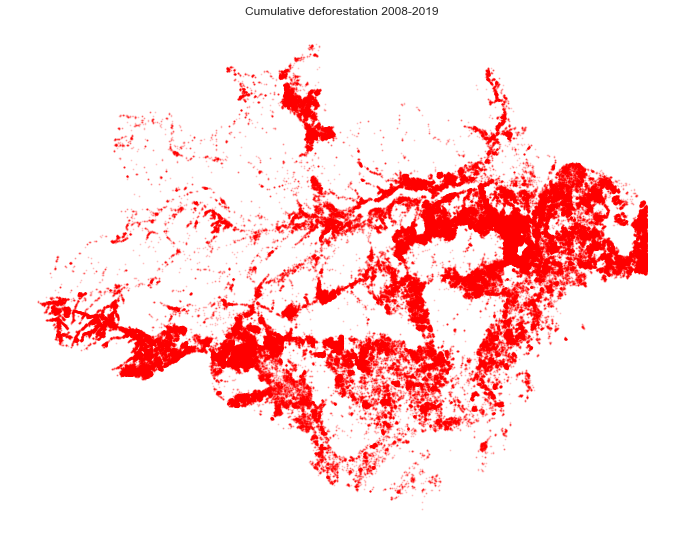

In [11]:
#Visualize deforestation

df_year['center'].plot(figsize=(12,12), alpha=0.15, c='red', markersize=1).set_title('Cumulative deforestation 2008-2019')

plt.axis('off') ;

In [12]:
#Filter amazon counties with official IBGE database

mun['cod_ibge'] = mun['cod_ibge'].astype('int')

counties = am_counties.merge(mun, on='cod_ibge', how='left')

counties = gpd.GeoDataFrame(counties)

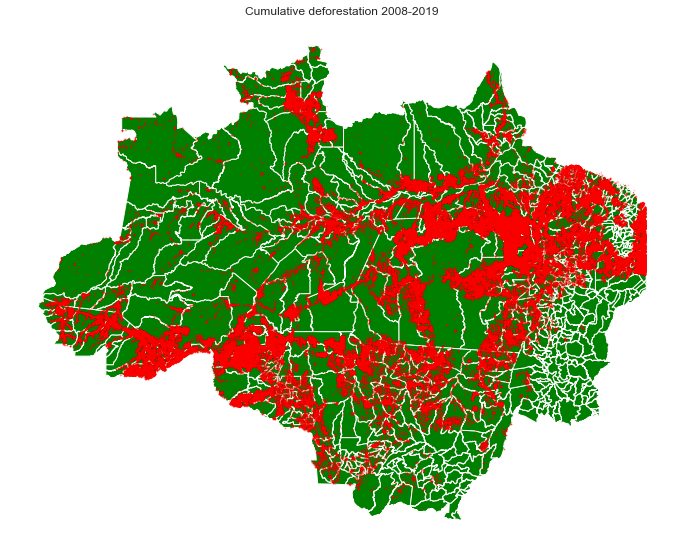

In [13]:
#Overlapping the counties and deforestation focus points  

fig, ax = plt.subplots(figsize=(12, 12))

counties.plot(column='municipios', color='green', ax=ax) 
df_year['center'].plot(c='red', alpha=0.2, markersize=0.5, ax=ax)
ax.set_title('Cumulative deforestation 2008-2019')

plt.axis('off')  ;

## 2.2 Deforestation in the Counties

We **only have the deforestation focus** information. Now, the **goal** here is to discover in **which countie** is **each deforestation geometry** 

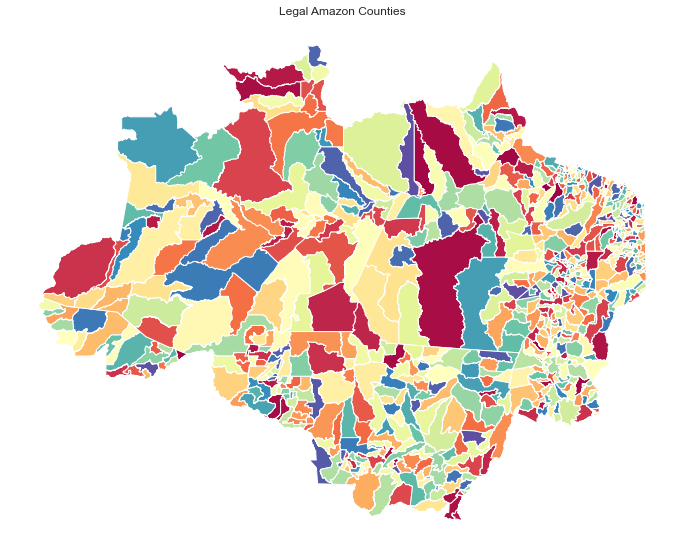

In [14]:
#Counties

counties.plot(column='municipios', cmap='Spectral', figsize=(12,12)).set_title('Legal Amazon Counties')
plt.axis('off') ;

In [15]:
#Spacial join 

df1 = gpd.sjoin(df_year, mun, how='inner', op='within')

In [16]:
#Drop residual column
df1.drop(['index_right'], axis=1, inplace=True)

df1.head(2)

state_year  julian_year  year_year  area_year                                           geometry                      center municipios  uf  cod_ibge
0          PA        202.0     2018.0   0.000071  POLYGON ((-55.42015 -6.30352, -55.42008 -6.303...  POINT (-55.42005 -6.30350)   ITAITUBA  PA   1503606
58         PA        220.0     2016.0   0.836838  POLYGON ((-56.16317 -6.45624, -56.16316 -6.456...  POINT (-56.15820 -6.45335)   ITAITUBA  PA   1503606

## 2.3 Adding indigenous areas

The intention is now see **which deforestation focus** is in **indigenous areas**

**Conclusion**: the overall **percentage proportion of deforestation points** in protected areas is **3.31%**

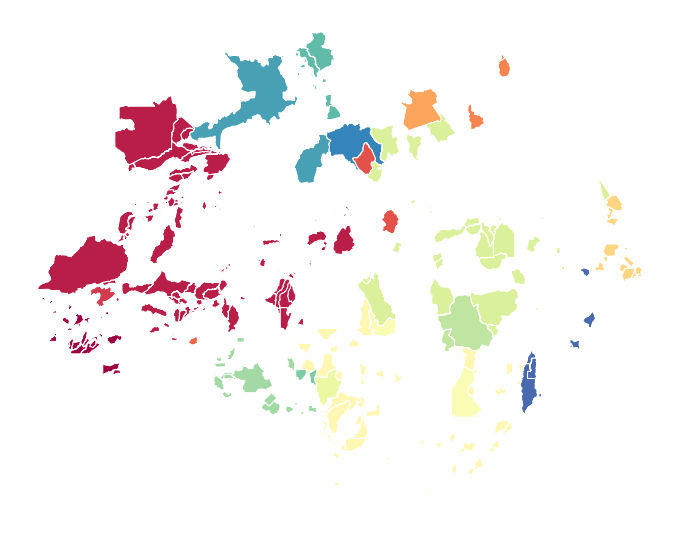

In [17]:
#Indigenous areas

indigenas.plot(column='uf_ind',figsize=(12,12), cmap='Spectral') 
plt.axis('off') ;

In [18]:
#Spacial join - indegenous areas

df2 = gpd.sjoin(df1, indigenas, how='left', op='within')

In [19]:
#Drop residual column
df2.drop(['index_right'], axis=1, inplace=True)

df2.head(2)

state_year  julian_year  year_year  area_year                                           geometry                      center municipios  uf  cod_ibge uf_ind
0          PA        202.0     2018.0   0.000071  POLYGON ((-55.42015 -6.30352, -55.42008 -6.303...  POINT (-55.42005 -6.30350)   ITAITUBA  PA   1503606    NaN
58         PA        220.0     2016.0   0.836838  POLYGON ((-56.16317 -6.45624, -56.16316 -6.456...  POINT (-56.15820 -6.45335)   ITAITUBA  PA   1503606    NaN

In [20]:
#Replace to 'yes' or 'no' if it is in indigenous areas

df2.rename({'uf_ind':'is_indigenous'}, axis=1, inplace=True)
df2['is_indigenous'].fillna(0, inplace=True)
df2['is_indigenous'] = df2['is_indigenous'].apply(lambda x: 'no' if x==0 else 'yes')

In [21]:
#Proportion of deforestation in indigenous reserves

(df2['is_indigenous'].value_counts(normalize=True)*100).round(2)

no     96.69
yes     3.31
Name: is_indigenous, dtype: float64

# 3.0 Joining numerical databases

The **spacial information** used until this point **is based on deforestation focus areas**. Since those points were localized into counties, the next step is to **use the counties as the anchoring point for the analysis** and then **aggregate other sources** of information to the dataset

In [22]:
#Transform GeoDataFrame into a Pandas DataFrame

df4 = df2.copy()
df4.drop('geometry', axis=1, inplace=True)
df4 = pd.DataFrame(df4)

## 3.1 Transforming the database

Transform the **Deforestation** and **Indigenous areas** into a database **based on Counties** 

### 3.1.1 Deforestation per countie

**Transforming** the deforestation data **to be based on Counties**

In [23]:
#Transform GeoDataFrame into a Pandas DataFrame

df_mun = counties.copy()
df_mun.drop('geometry', axis=1, inplace=True)
df_mun = pd.DataFrame(df_mun)

In [24]:
#See how many counties there are deforestation focus points - 635 counties

unique = pd.DataFrame(df4['cod_ibge'].unique())

unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       635 non-null    int32
dtypes: int32(1)
memory usage: 2.6 KB


In [25]:
#Reshape deforesation database to be based on the Counties

defor = df4.pivot_table(values='area_year', index='cod_ibge', columns='year_year', aggfunc=[sum])
defor.reset_index(inplace=True)
defor.columns = ['cod_ibge', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'] 

defor.head()

cod_ibge       2008      2009      2010      2011      2012       2013       2014       2015       2016       2017       2018       2019
0   1100015  26.076179  4.973513  1.783824  6.812662  5.212617   6.415585  10.296426   4.980956  15.546449  19.091925  13.804002  29.925871
1   1100023   7.849624  8.590218  3.961204  3.701628  7.057179  11.509216   9.657719  10.086146  29.906891  20.316906  16.724651  17.847052
2   1100031   3.815589  0.889626  1.180706  0.743992  0.992416   1.388728   4.993650   6.787937   6.851192   1.871430   3.181438   4.708874
3   1100049   4.612071  2.886978  1.659751  2.314804  3.237873   1.813584   4.279031   2.323798   2.931519   7.884689   4.755924   5.923687
4   1100056   2.229888  0.578362  0.949371  1.678473  1.260044   0.588267   2.648019   2.925582   5.668583   1.678868   0.897983   0.936262

In [26]:
#Merge - Database with all the Counties + Deforestation database based on counties 

defor['cod_ibge'] = defor['cod_ibge'].astype('int')

deforestation = pd.merge(defor, df_mun, how='left', on=['cod_ibge'])

In [27]:
#As not all counties have deforestation focus points, subistitute NaNs values with zeros

deforestation.fillna(value=0, inplace=True)

In [28]:
#Reshape database
deforestation = deforestation.melt(id_vars=['cod_ibge', 'municipios', 'uf'], var_name='year', value_name='deforestation')                     


In [29]:
#See reshaped database

deforestation.head(2)

cod_ibge             municipios  uf  year deforestation
0   1100015  ALTA FLORESTA D'OESTE  RO  2008     26.076179
1   1100023              ARIQUEMES  RO  2008      7.849624

In [30]:
#Concatenate - create unique key 

deforestation['cod_ibge'] = deforestation['cod_ibge'].astype(str)

deforestation['year'] = deforestation['year'].astype(str)

deforestation['concat'] = deforestation['cod_ibge'] + deforestation['year']

### 3.1.2 Indigenous ratio per countie

**Transforming** the indigenous data **to be based on Counties**. Since the 'is_indigenous' columns indicates if the deforestation focus is or isn't located at a indigenous area, the **total per Countie will be calculated as a proportion** of that. *Example*: if a **Countie has 100 deforestation focus points** and **15 of them are in indigenous areas**, the proportion will be **0.15** 

In [31]:
#Indigenous proportion

df4['ind_propor'] = df4['is_indigenous'].apply(lambda x: 1 if x=='yes' else 0)

In [32]:
#Create dataset based on Counties for each year

pvt_ind_2008 = pvt_ind(2008) #see function definition in helper functions

pvt_ind_2009 = pvt_ind(2009)

pvt_ind_2010 = pvt_ind(2010)

pvt_ind_2011 = pvt_ind(2011)

pvt_ind_2012 = pvt_ind(2012)

pvt_ind_2013 = pvt_ind(2013)

pvt_ind_2014 = pvt_ind(2014)

pvt_ind_2015 = pvt_ind(2015)

pvt_ind_2016 = pvt_ind(2016)

pvt_ind_2017 = pvt_ind(2017)

pvt_ind_2018 = pvt_ind(2018)

pvt_ind_2019 = pvt_ind(2019)

In [33]:
#Merge all the year based data

df_ind = pvt_ind_2008.merge(pvt_ind_2009, on='cod_ibge', how='outer')

df_ind = df_ind.merge(pvt_ind_2010, on='cod_ibge', how='outer')

df_ind = df_ind.merge(pvt_ind_2011, on='cod_ibge', how='outer')

df_ind = df_ind.merge(pvt_ind_2012, on='cod_ibge', how='outer')

df_ind = df_ind.merge(pvt_ind_2013, on='cod_ibge', how='outer')

df_ind = df_ind.merge(pvt_ind_2014, on='cod_ibge', how='outer')

df_ind = df_ind.merge(pvt_ind_2015, on='cod_ibge', how='outer')

df_ind = df_ind.merge(pvt_ind_2016, on='cod_ibge', how='outer')

df_ind = df_ind.merge(pvt_ind_2017, on='cod_ibge', how='outer')

df_ind = df_ind.merge(pvt_ind_2018, on='cod_ibge', how='outer')

df_ind = df_ind.merge(pvt_ind_2019, on='cod_ibge', how='outer')

df_ind.columns = ['cod_ibge', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']            


In [34]:
#See the result

df_ind.head(2)

cod_ibge      2008      2009  2010      2011      2012      2013      2014      2015      2016      2017  2018     2019
0   1100015  1.724138  7.142857   0.0  7.272727  3.225806  4.081633  4.477612  2.702703  2.564103  1.754386   0.0  4.83871
1   1100023  0.000000  0.000000   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0  0.00000

In [35]:
#Reshape to tabular data

df_ind = df_ind.melt(id_vars='cod_ibge', var_name='year', value_name='ind_propor')                  


In [36]:
#See dtaa reshaped

df_ind.head(2)

cod_ibge  year  ind_propor
0   1100015  2008    1.724138
1   1100023  2008    0.000000

In [37]:
#Concatenate strings - create unique key

df_ind['cod_ibge'] = df_ind['cod_ibge'].astype('str')

df_ind['concat'] = df_ind['cod_ibge'] + df_ind['year']

### 3.1.3 Joining all the data per countie

Finally, **all the data based on Counties will be merged**. The strategy is to **merge** on the **concatenated key columns**. The logic is that there is the **information per Countie** identified by an **unique IBGE key** by **different years**.Therefore, the **IBGE key+year** corresponds **to an unique information**. The **same logic will be applied** to merge the proportional deforestation in **indigenous** and **conservation areas** that are also distinct depending of the year

In [38]:
#Merge - deforestation by Countie by year + Indigenous proportion of deforestation by Countie by year

df_counties = deforestation.merge(df_ind, on='concat', how='left')


In [39]:
#Drop duplicated columns

df_counties.drop(['cod_ibge_y', 'year_y'], axis=1, inplace=True)

df_counties.columns = ['cod_ibge', 'municipios', 'uf', 'year', 'deforestation', 'concat', 'ind_propor']

## 3.2 Add other sources of data

After reshaping the database to be based on Counties, **Characteristics**, **Rural Industry** and **Social & Economic** data per Countie **is going to be added**

### 3.2.1 Countie's total area

It is important to add the **total area of the Counties** to have an idea of **how much the deforestation area represents**. Not all counties have deforestation focus, so the **GeoDataFrame of Counties** will be **transformed into a pandas DataFrame** and used as reference. **From a total of 772 counties**, **635 have deforestation focus points** which corresponds to **82,3%** of them

In [40]:
#Use counties as a reference

counties = df_mun.copy()

In [41]:
#All counties 

total = (counties['cod_ibge'])

len(total)

772

In [42]:
#Counties that have deforestation focus points 

total = df_counties['cod_ibge'].unique()

len(total)

635

In [43]:
#Prepare to merge - Create empty columns by year 

years = ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

for year in years:
    counties[year] = 0

In [44]:
#See result

counties.head(2)

cod_ibge              municipio             municipios  uf  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019
0   1100015  Alta Floresta D'Oeste  ALTA FLORESTA D'OESTE  RO     0     0     0     0     0     0     0     0     0     0     0     0
1   1100023              Ariquemes              ARIQUEMES  RO     0     0     0     0     0     0     0     0     0     0     0     0

In [45]:
#Reshape Counties DataFrame to tabular format 

counties = counties.melt(id_vars=['cod_ibge', 'municipios', 'uf'], var_name='year', value_name='x')                  


In [46]:
#See reshape result

counties.head(2)

cod_ibge             municipios  uf       year                      x
0   1100015  ALTA FLORESTA D'OESTE  RO  municipio  Alta Floresta D'Oeste
1   1100023              ARIQUEMES  RO  municipio              Ariquemes

In [47]:
#Drop residual colum

counties.drop('x', axis=1, inplace=True)

In [48]:
#Concatenate - create unique key

counties['cod_ibge'] = counties['cod_ibge'].astype('int')

counties['cod_ibge'] = counties['cod_ibge'].astype('str')

counties['concat'] = counties['cod_ibge'] + counties['year']

In [49]:
#Outer merge with all Counties database

df_counties = df_counties.merge(counties, how='outer', on='concat')


In [50]:
#Drop residual columns

df_counties.drop(['cod_ibge_x', 'municipios_x', 'uf_x', 'year_x'], axis=1, inplace=True)

In [51]:
#Rename columns

df_counties.columns = ['deforestation', 'concat', 'ind_propor', 'cod_ibge', 'municipios', 'uf', 'year']

In [52]:
#Fill NaNs with zero 

df_counties.fillna(0, inplace=True)

In [53]:
#Countie areas Dataframe - drop empty rows

area_mun.dropna(inplace=True)

In [54]:
area_mun.head()

cod_ibge              municipio  area_km2
0  1100015.0  ALTA FLORESTA D'OESTE  7067,025
1  1100023.0              ARIQUEMES  4426,571
2  1100031.0                 CABIXI  1314,352
3  1100049.0                 CACOAL  3792,892
4  1100056.0             CEREJEIRAS    2783,3

In [55]:
#Put the area_km2 information in all years 

for year in years:
    area_mun[year] = area_mun['area_km2']

area_mun.drop(['area_km2', 'municipio'], axis=1, inplace=True)    

In [56]:
#See result in DataFrame

area_mun.head(2)

cod_ibge      2008      2009      2010      2011      2012      2013      2014      2015      2016      2017      2018      2019
0  1100015.0  7067,025  7067,025  7067,025  7067,025  7067,025  7067,025  7067,025  7067,025  7067,025  7067,025  7067,025  7067,025
1  1100023.0  4426,571  4426,571  4426,571  4426,571  4426,571  4426,571  4426,571  4426,571  4426,571  4426,571  4426,571  4426,571

In [57]:
#Reshape to tabular data

area_mun = area_mun.melt(id_vars=['cod_ibge'], var_name='year', value_name='area_countie')                     


In [58]:
#See reshaped in DataFrame

area_mun.head(2)

cod_ibge  year area_countie
0  1100015.0  2008     7067,025
1  1100023.0  2008     4426,571

In [59]:
#Concatenate strings - create unique key

area_mun['cod_ibge'] = area_mun['cod_ibge'].astype('int')

area_mun['cod_ibge'] = area_mun['cod_ibge'].astype('str')

area_mun['concat'] = area_mun['cod_ibge'] + area_mun['year']

In [60]:
#Merge databases

df_area = df_counties.merge(area_mun, on='concat', how='inner')

In [61]:
#Drop and rename columns 

df_area.drop(['cod_ibge_y', 'year_y'], axis=1, inplace=True)

df_area.columns = ['deforestation', 'concat', 'ind_propor', 'cod_ibge', 'municipios', 'uf', 'year', 'area_countie']           


### 3.2.2 Demographic data

The **Demographic is also important** when considering the **social and economic aspects** of **Counties** and **States**. Here, it is assumed a **constant population**  

In [62]:
#See dem dataset

dem.head(2)

cod_ibge               municipio state  population
0   1100015  Alta Floresta D'Oeste     RO       22728
1   1100023              Ariquemes     RO      109523

In [63]:
#Put the Demographic information in all years 

for year in years:
    dem[year] = dem['population']

dem.drop(['population', 'state'], axis=1, inplace=True)    

In [64]:
#See result in DataFrame

dem.head(2)

cod_ibge               municipio    2008    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019
0   1100015  Alta Floresta D'Oeste    22728   22728   22728   22728   22728   22728   22728   22728   22728   22728   22728   22728
1   1100023              Ariquemes   109523  109523  109523  109523  109523  109523  109523  109523  109523  109523  109523  109523

In [65]:
#Reshape to tabular data

dem = dem.melt(id_vars=['cod_ibge', 'municipio'], var_name='year', value_name='population')                     


In [66]:
#See reshaped in DataFrame

dem.head(2)

cod_ibge               municipio  year  population
0   1100015  Alta Floresta D'Oeste   2008       22728
1   1100023              Ariquemes   2008      109523

In [67]:
#Concatenate strings - create unique key

dem['cod_ibge'] = dem['cod_ibge'].astype('str')

dem['concat'] = dem['cod_ibge'] + dem['year']

In [68]:
#Merge the databases 

df_area['cod_ibge'] = df_area['cod_ibge'].astype('int')

df_dem = df_area.merge(dem, how='left', on='concat')

In [69]:
#Drop and rename columns 

df_dem.drop(['municipios', 'cod_ibge_x', 'year_y'], axis=1, inplace=True)

df_dem.columns = ['deforestation', 'concat', 'ind_propor', 'uf', 'year', 'area_countie', 'cod_ibge', 'municipio', 'population']


### 3.2.3 Agriculture data

The agriculture data is a **very important aspect to consider** since there is a **possibility that it might impact deforestation**. Here, it is going to be considered the **agriculture data** provided for **each year of the analysis**. The **measure** of the data is **hectares planted**

In [70]:
agriculture.head(2)

codigo_ibge               municipio   2008   2009   2010   2011   2012   2013   2014   2015   2016   2017   2018   2019
0      1100015  Alta Floresta D'Oeste   16870  18817  17065  19532  19402  16103  13664  11239  11594  11222  11408  11410
1      1100023              Ariquemes    7656  10866  13271   7042   6160   4663   4418   4723   4371   5462   7694  10344

In [71]:
#Reshape to tabular data

agriculture = agriculture.melt(id_vars=['codigo_ibge', 'municipio'], var_name=['year'], value_name='area_agri')

In [72]:
agriculture.head(2)

codigo_ibge               municipio  year  area_agri
0      1100015  Alta Floresta D'Oeste   2008      16870
1      1100023              Ariquemes   2008       7656

In [73]:
#Concatenate - create unique keys

agriculture['codigo_ibge'] = agriculture['codigo_ibge'].astype('str')

agriculture['concat'] = agriculture['codigo_ibge'] + agriculture['year']


In [74]:
#Merge the databases 

df_agri = df_dem.merge(agriculture, how='left', on='concat')


In [75]:
#Drop and rename columns 

df_agri.drop(['codigo_ibge', 'year_y', 'municipio_y'], axis=1, inplace=True)

df_agri.columns = ['deforestation', 'concat', 'ind_propor', 'uf', 'year', 'area_countie', 'cod_ibge', 'municipio', 'population', 'area_agri']   


### 3.2.4 Cattle data

The cattle data is also a **very relevant aspect to consider** since it is one of the **potential causes for deforestation**. It is also going to be considered the **cattle data** for **each year of the analysis**. The **measure** of the data is **head of cattle**

In [76]:
cattle.head(2)

cod_ibge               municipio      2008      2009      2010      2011      2012      2013      2014      2015      2016      2017      2018      2019
0   1100015  Alta Floresta D'Oeste   356190.0  355942.0  364184.0  365538.0  372731.0  386456.0  391388.0  407890.0  403973.0  408765.0  421964.0  428976.0
1   1100023              Ariquemes   423750.0  440053.0  439355.0  446471.0  442851.0  427419.0  431871.0  455731.0  449108.0  477322.0  491414.0  477665.0

In [77]:
#Reshape to tabular data

cattle = cattle.melt(id_vars=['cod_ibge', 'municipio'], var_name=['year'], value_name='cattle')

In [78]:
cattle.head(2)

cod_ibge               municipio  year    cattle
0   1100015  Alta Floresta D'Oeste   2008  356190.0
1   1100023              Ariquemes   2008  423750.0

In [79]:
#Concatenate - create unique key

cattle['cod_ibge'] = cattle['cod_ibge'].astype('str')

cattle['concat'] = cattle['cod_ibge'] + cattle['year']

In [80]:
#Merge the databases 

df_cattle = df_agri.merge(cattle, how='left', on='concat')


In [81]:
#Drop and rename columns 

df_cattle.drop(['cod_ibge_x', 'year_x', 'municipio_x'], axis=1, inplace=True)

df_cattle.columns = ['deforestation', 'concat', 'ind_propor', 'uf', 'area_countie', 'population', 'area_agri', 'cod_ibge', 'municipio', 'year', 'bov_head']                        


### 3.2.5 GDP - Gross Domestic Product

A **key factor of the economic aspect** of Counties and States is the **Gross Domestic Product**. It is the **total of all the finished goods and services produced** within a location. Here, we have the data of **GDP per Countie for each year of the analysis**. Since the **2019 estimated GDP is not available**, we'll use the **2018 estimation**




In [82]:
#See PIB DataFrame

pib.head(2)

cod_ibge               municipio state    2002    2003    2004    2005    2006    2007     2008     2009     2010     2011     2012     2013     2014     2015     2016     2017     2018
0   1100015  Alta Floresta D'Oeste     RO  111291  143222  173991  167127  168805  191364   248962   256986   262077   280510   329029   341325   377799   421300   478217   485374   499306
1   1100023              Ariquemes     RO  449593  539636  657193  749021  790697  905203  1064822  1133095  1364694  1651885  1703642  1799853  1921532  2037799  2184346  2287910  2463773

In [83]:
#Drop years not present in the analysis

pib.drop(['2002', '2003', '2004', '2005', '2006', '2007'], axis=1, inplace=True)


In [84]:
#Create 2019 columns - copy 2018's estimation

pib['2019'] = pib['2018']

In [85]:
#Reshape to tabular data

pib = pib.melt(id_vars=['cod_ibge', 'municipio','state'], var_name=['year'], value_name='gdp')

In [86]:
#See reshaped DataFrame

pib.head(2)

cod_ibge               municipio state  year      gdp
0   1100015  Alta Floresta D'Oeste     RO  2008   248962
1   1100023              Ariquemes     RO  2008  1064822

In [87]:
#Concatenate - create unique key

pib['cod_ibge'] = pib['cod_ibge'].astype('str')

pib['concat'] = pib['cod_ibge'] + cattle['year']

In [88]:
#Merge the databases 

df_gdp = df_cattle.merge(pib, how='left', on='concat')


In [89]:
#Drop and rename columns 

df_gdp.drop(['cod_ibge_y', 'year_x', 'municipio_x'], axis=1, inplace=True)

df_gdp.columns = ['deforestation', 'concat', 'ind_propor', 'uf', 'area_countie', 'population', 'area_agri', 'cod_ibge', 'bov_head', 'municipio', 'state', 'year', 'gdp']     


### 3.2.6 HDI - Human Development Index

When considering the **social and economic aspects**, another indispensable factor is the **Human Development Index**. For each Countie, it's going to be added to the dataset: **HDI**, **Income HDI**, **Education HDI** and **Longevity HDI**. Here, we'll assume the **HDI values are constant**

In [90]:
#Delete not necessary columns

idh.drop(['posição_IDHM', 'posição_IDHM_renda', 'posição_IDHM_educacao', 'posicao_IDHM_longevidade','Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26'], axis=1, inplace=True)


In [91]:
#See HDI DataFrame

idh.head(2)

municipio state_idh   IDHM IDHM_renda IDHM_educacao IDHM_longevidade
0      abadia de goias        GO  0,708       0,83         0,622            0,687
1  abadia dos dourados        MG  0,689      0,839         0,563            0,693

In [92]:
#See IBGe code DataFrame

cod_ibge.head(2)

cod_ibge              municipio state_cod_ibge
0   1100015  alta floresta d'oeste             RO
1   1100023              ariquemes             RO

In [93]:
#Create concatenate columns - municipio + state

idh['concat'] = idh['municipio'] + idh['state_idh']
cod_ibge['concat'] = cod_ibge['municipio'] + cod_ibge['state_cod_ibge']

In [94]:
#Merge databases to get IBGE code

idh_ibge = idh.merge(cod_ibge, on='concat', how='left')

In [95]:
#Drop not necessary columns

idh_ibge.dropna(inplace=True)
idh_ibge.drop(['municipio_y', 'state_idh','state_cod_ibge'], axis=1, inplace=True)
idh_ibge.columns = ['municipio', 'IDHM', 'IDHM_renda', 'IDHM_educacao', 'IDHM_longevidade', 'concat', 'cod_ibge']

In [96]:
#Create DataFrames with different HDI

HDI = idh_ibge[['cod_ibge', 'IDHM']]

HDI_income = idh_ibge[['cod_ibge', 'IDHM_renda']]

HDI_education = idh_ibge[['cod_ibge', 'IDHM_educacao']]

HDI_longevity = idh_ibge[['cod_ibge', 'IDHM_longevidade']]


In [97]:
#Use custom function to generate melted DataFrames by year 

HDI = melt_idh(HDI, 'IDHM') #see more details of this function on the helper function section

HDI_income = melt_idh(HDI_income, 'IDHM_renda')

HDI_education = melt_idh(HDI_education, 'IDHM_educacao')

HDI_longevity = melt_idh(HDI_longevity, 'IDHM_longevidade')


In [98]:
#Concatenate columns - cod_ibge + year

dataframe = [HDI, HDI_income, HDI_education, HDI_longevity]

for df in dataframe:
    df['cod_ibge'] = df['cod_ibge'].astype('int')
    df['cod_ibge'] = df['cod_ibge'].astype('str')

for df in dataframe:
    df['concat'] = df['cod_ibge'] + df['year']
    df.drop(['cod_ibge', 'year'], axis=1, inplace=True)


In [99]:
#Merge all HDI DataFrames

HDI_full = HDI.merge(HDI_income, on='concat')

HDI_full = HDI_full.merge(HDI_education, on='concat')

HDI_full = HDI_full.merge(HDI_longevity, on='concat')


In [100]:
#Merge wih the full DataFrame

df_full = df_gdp.merge(HDI_full, how='left', on='concat')


# 4.0 Custom DataFrames  

Now that all information is aggregated in just one database, it is **strategic to create custom DataFrames** to make possible the following **Exploratory Data Analysis** and **Machine Learning Modelling**

The dataset has **deforestation data of 12 years (2008-2019)**. The strategy is to compute the **overall information throughout the years** with **cumulative deforestation**

Likewise, **all the time sensitive data is going to be in the same cumulative frame**, that is: **Agriculture**, **Cattle** and **GDP** data. For **indigenous areas**, the information is going to be **if there is deforestation in protected reserves in the Countie**. All **Human Development indexes** are considered **constant**

## 4.1 States 

To get a **first overview of the data**, it is a good practice to first **organize it in States frame**. It is important to highlight that, **in some cases**, this **sum do not correspond to all the Counties of that state**, just Counties that are in the **Legal Amazon**. For example, **only a few Counties of Maranhão state are in Legal Amazon**, therefore, the **sum of these Counties does not correspond to the official numbers** of all Counties of the state

In [101]:
#Cumulative Deforestation
def_acc = df_full.pivot_table(values='deforestation', index='uf', aggfunc=['sum'])
def_acc.columns = ['def_acc'] 

#Cumulative Agriculture
agri_acc = df_full.pivot_table(values='area_agri', index='uf', aggfunc=['sum'])
agri_acc.columns = ['agri_acc']  

#Cumulative Cattle
cattle_acc = df_full.pivot_table(values='bov_head', index='uf', aggfunc=['sum'])
cattle_acc.columns = ['cattle_acc'] 

#Cumulative Cattle
gdp_acc = df_full.pivot_table(values='gdp', index='uf', aggfunc=['sum'])
gdp_acc.columns = ['gdp_acc'] 

In [102]:
#Cumulative Deforestation
def_acc = df_full.pivot_table(values='deforestation', index='uf', aggfunc=['sum'])
def_acc.columns = ['def_acc'] 

#Cumulative Agriculture
agri_acc = df_full.pivot_table(values='area_agri', index='uf', aggfunc=['sum'])
agri_acc.columns = ['agri_acc']  

#Cumulative Cattle
cattle_acc = df_full.pivot_table(values='bov_head', index='uf', aggfunc=['sum'])
cattle_acc.columns = ['cattle_acc'] 

#Cumulative Cattle
gdp_acc = df_full.pivot_table(values='gdp', index='uf', aggfunc=['sum'])
gdp_acc.columns = ['gdp_acc'] 

In [103]:
#Merge all previous DataFrames 

df_state = def_acc.merge(agri_acc, left_on=def_acc.index, right_on=agri_acc.index)

df_state = df_state.merge(cattle_acc, left_on='key_0', right_on=cattle_acc.index)

df_state = df_state.merge(gdp_acc, left_on='key_0', right_on=gdp_acc.index)

df_state.rename({'key_0':'state'}, axis=1, inplace=True)
df_state.set_index('state', inplace=True)

In [104]:
#Transform Data Types - transform before merging DataFrames

df_full['IDHM'] = df_full['IDHM'].str.replace(',','.')
df_full['IDHM'] = df_full['IDHM'].astype('float')

df_full['IDHM_renda'] = df_full['IDHM_renda'].str.replace(',','.')
df_full['IDHM_renda'] = df_full['IDHM_renda'].astype('float')

df_full['IDHM_educacao'] = df_full['IDHM_educacao'].str.replace(',','.')
df_full['IDHM_educacao'] = df_full['IDHM_educacao'].astype('float')

df_full['IDHM_longevidade'] = df_full['IDHM_longevidade'].str.replace(',','.')
df_full['IDHM_longevidade'] = df_full['IDHM_longevidade'].astype('float')

df_full['area_countie'] = df_full['area_countie'].str.replace(',','.')
df_full['area_countie'] = df_full['area_countie'].astype('float')

In [105]:
#Create Dataframe with constant features

state_area = pvt_sum('area_countie')      #see more details in helper functions

state_pop = pvt_sum('population')

state_HDI = pvt_mean('IDHM')             #see more details in helper functions

state_HDI_income = pvt_mean('IDHM_renda')

state_HDI_education = pvt_mean('IDHM_educacao')

state_HDI_longevity = pvt_mean('IDHM_longevidade')

In [106]:
#Merge all DataFrames with constant features

const_full = state_area.merge(state_pop, left_on=state_area.index, right_on=state_pop.index)

const_full = const_full.merge(state_HDI, left_on='key_0', right_on=state_HDI.index)

const_full = const_full.merge(state_HDI_income, left_on='key_0', right_on=state_HDI_income.index)

const_full = const_full.merge(state_HDI_education, left_on='key_0', right_on=state_HDI_education.index)

const_full = const_full.merge(state_HDI_longevity, left_on='key_0', right_on=state_HDI_longevity.index)

const_full.rename({'key_0':'state'}, axis=1, inplace=True)
const_full.set_index('state', inplace=True)

In [107]:
#Final DataFrame - merge Dataframes with linear regressions and constant features

df_state = df_state.merge(const_full, left_on=df_state.index, right_on=const_full.index)
df_state.rename({'key_0':'state'}, axis=1, inplace=True)
df_state.set_index('state', inplace=True)

## 4.2 Counties 

Now it is time to make the **same process** with the **Counties database** which is going to be the **base of the analysis** and **Machine Learning modelling**

In [108]:
#Cumulative Deforestation
def_acc_countie = df_full.pivot_table(values='deforestation', index='cod_ibge', aggfunc=['sum'])
def_acc_countie.columns = ['def_acc'] 

#Cumulative agriculture
agri_acc_countie = df_full.pivot_table(values='area_agri', index='cod_ibge', aggfunc=['sum'])
agri_acc_countie.columns = ['agri_acc'] 

#Cumulative cattle
cattle_acc_countie = df_full.pivot_table(values='bov_head', index='cod_ibge', aggfunc=['sum'])
cattle_acc_countie.columns = ['cattle_acc'] 

#Cumulative GDP
gdp_acc_countie = df_full.pivot_table(values='gdp', index='cod_ibge', aggfunc=['sum'])
gdp_acc_countie.columns = ['gdp_acc'] 

In [109]:
#Indigenous areas - Cumulative proportion
ind_acc_countie = df_full.pivot_table(values='ind_propor', index='cod_ibge', aggfunc=['sum'])
ind_acc_countie.columns = ['ind_acc']  

In [110]:
#Merge all previous DataFrames 

df_countie = def_acc_countie.merge(agri_acc_countie, left_on=def_acc_countie.index, right_on=agri_acc_countie.index)

df_countie = df_countie.merge(cattle_acc_countie, left_on='key_0', right_on=cattle_acc_countie.index)

df_countie = df_countie.merge(gdp_acc_countie, left_on='key_0', right_on=gdp_acc_countie.index)

df_countie = df_countie.merge(ind_acc_countie, left_on='key_0', right_on=ind_acc_countie.index)

df_countie.rename({'key_0':'cod_ibge'}, axis=1, inplace=True)
df_countie.set_index('cod_ibge', inplace=True)

In [111]:
#Create Dataframe with constant features

countie_area = countie_pvt_sum('area_countie')        #see more details in helper functions

countie_pop = countie_pvt_sum('population')

countie_HDI = countie_pvt_mean('IDHM')                #see more details in helper functions

countie_HDI_income = countie_pvt_mean('IDHM_renda')

countie_HDI_education = countie_pvt_mean('IDHM_educacao')

countie_HDI_longevity = countie_pvt_mean('IDHM_longevidade')

In [112]:
#Merge all DataFrames with constant features

countie_const_full = countie_area.merge(countie_pop, left_on=countie_area.index, right_on=countie_pop.index)

countie_const_full = countie_const_full.merge(countie_HDI, left_on='key_0', right_on=countie_HDI.index)

countie_const_full = countie_const_full.merge(countie_HDI_income, left_on='key_0', right_on=countie_HDI_income.index)

countie_const_full = countie_const_full.merge(countie_HDI_education, left_on='key_0', right_on=countie_HDI_education.index)

countie_const_full = countie_const_full.merge(countie_HDI_longevity, left_on='key_0', right_on=countie_HDI_longevity.index)

countie_const_full.rename({'key_0':'cod_ibge'}, axis=1, inplace=True)
countie_const_full.set_index('cod_ibge', inplace=True)

In [113]:
#Final DataFrame 

df_countie = df_countie.merge(countie_const_full, left_on=df_countie.index, right_on=countie_const_full.index)
df_countie.rename({'key_0':'cod_ibge'}, axis=1, inplace=True)
df_countie.set_index('cod_ibge', inplace=True)

# 5.0 Exploratory Data Analysis 

The goal is to **explore** and **understand** the dataset. The strategy is first make a **quick descriptive analysis** and then go deeper in a **hyphotesis driven analysis**

## 5.1 Univariate descriptive analysis

The intention is to **get an overall feeling about the dataset**. Since we have a lot of variables, for this quick univariate descriptive only **deforestation** (*target variable*), **agriculture** and **cattle** will be analysed

### 5.1.1 States

It is important to **overview** the **states** data **before diving** into the **Counties**

#### 5.1.1.1 Deforestation - target variable

**Conclusion**: states that stand out in cumulative deforestation are **PA**, **MT**, **RO** and **AM**

In [114]:
#States with greatest slope
a = df_state
a['def_acc_rank'] = a['def_acc'].rank(ascending=False) 

a[['def_acc_rank']]

def_acc_rank
state              
AC              6.0
AM              4.0
AP              9.0
MA              5.0
MT              2.0
PA              1.0
RO              3.0
RR              7.0
TO              8.0

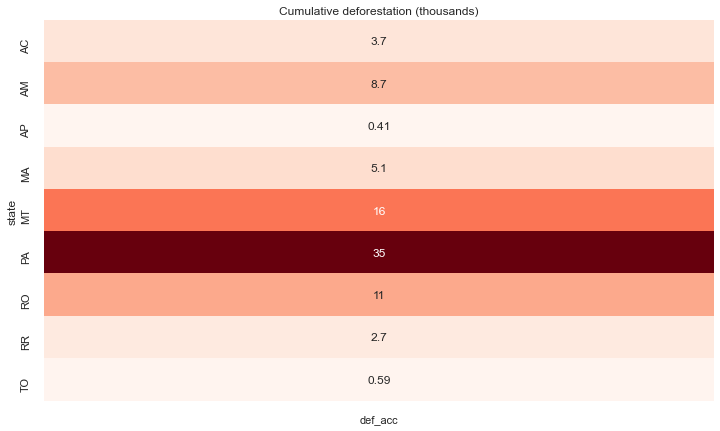

In [115]:
#See cumulative deforestation - states

plt.rcParams['figure.figsize'] = [12, 7]

sns.heatmap(a[['def_acc']]/10**3, annot=True, cmap='Reds', cbar=False).set_title('Cumulative deforestation (thousands)') ;


#### 5.1.1.2 Agriculture

**Conclusion**: states that stand out in cumulative agriculture are **MT** (by far), **MA**, **TO** and **PA**

In [116]:
#States with greatest slope
a['agri_acc_rank'] = a['agri_acc'].rank(ascending=False) 

a[['agri_acc_rank']]

agri_acc_rank
state               
AC               7.0
AM               6.0
AP               9.0
MA               2.0
MT               1.0
PA               4.0
RO               5.0
RR               8.0
TO               3.0

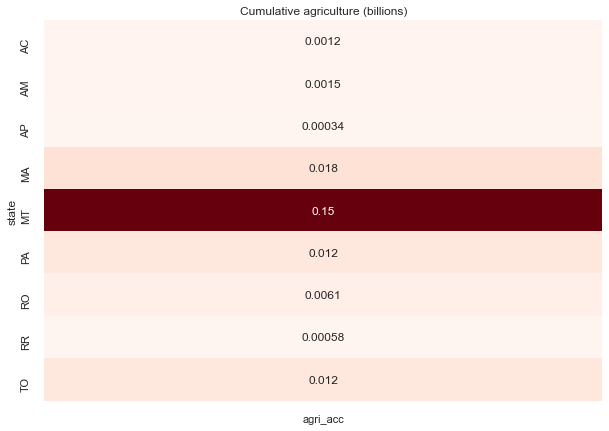

In [117]:
#See cumulative deforestation - states

plt.rcParams['figure.figsize'] = [10, 7]

sns.heatmap(a[['agri_acc']]/10**9, annot=True, cmap='Reds', cbar=False).set_title('Cumulative agriculture (billions)') ;


#### 5.1.1.3 Cattle

**Conclusion**: states that stand out in growing tendency in cattle are **MT**, **PA**, **RO** and **TO**

In [118]:
#States with greatest slope
a['cattle_acc_rank'] = a['cattle_acc'].rank(ascending=False) 

a[['cattle_acc_rank']]

cattle_acc_rank
state                 
AC                 6.0
AM                 7.0
AP                 9.0
MA                 5.0
MT                 1.0
PA                 2.0
RO                 3.0
RR                 8.0
TO                 4.0

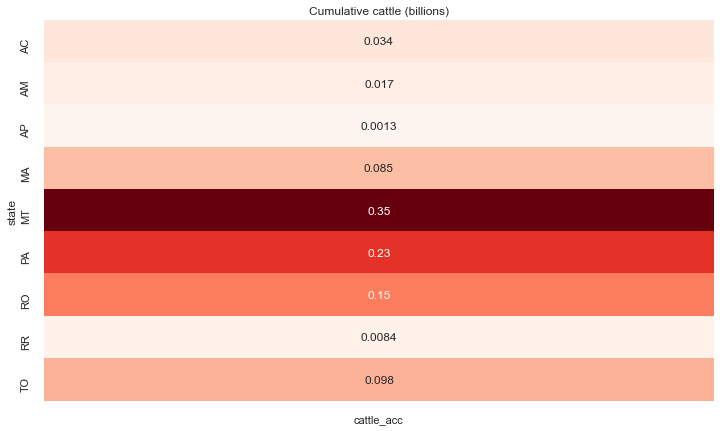

In [119]:
#See cumulative deforestation - states

plt.rcParams['figure.figsize'] = [12, 7]

sns.heatmap(a[['cattle_acc']]/10**9, annot=True, cmap='Reds', cbar=False).set_title('Cumulative cattle (billions)') ;


### 5.1.2 Counties

To get an overview of the Counties data, the **strategy** is to **divide Counties into quarters** to get a **better visualization** on the map 

#### 5.1.2.1 Deforestation - target variable

**Conclusion**: Counties classified as **high-high slope** cumulative deforestation are **near each other** and, in harmony with the states analysis, are in **PA**, **MT**, **RO** and **AM**

In [120]:
#Calculate quarters
def_acc_not_zero = df_countie[df_countie['def_acc'] != 0]

def_acc_not_zero['def_acc_quartile'] = 0
def_acc_not_zero.sort_values(by='def_acc', ascending=False, inplace=True)
def_acc_not_zero['def_acc_quartile'] = pd.qcut(def_acc_not_zero['def_acc'], q=4, duplicates='drop')

In [121]:
#Remove special characters

def_acc_not_zero['def_acc_quartile'] = def_acc_not_zero['def_acc_quartile'].astype('str')
def_acc_not_zero['def_acc_quartile'] = def_acc_not_zero['def_acc_quartile'].str.replace('(','')
def_acc_not_zero['def_acc_quartile'] = def_acc_not_zero['def_acc_quartile'].str.replace(']','')

In [122]:
def_acc_not_zero['def_acc_quartile'].unique()

array(['105.695, 3829.858', '24.917, 105.695', '6.169, 24.917',
       '0.0576, 6.169'], dtype=object)

In [123]:
#Replace for classification

class_dict = {'105.695, 3829.858':'high-high','24.917, 105.695':'low-high','6.169, 24.917':'high-low','0.0576, 6.169':'low-low'}

def_acc_not_zero['def_acc_quartile'] = def_acc_not_zero['def_acc_quartile'].map(class_dict)

In [124]:
#Merge with DataFrames with zero deforestation

def_acc_zero = df_countie[df_countie['def_acc'] == 0]

def_acc_countie_quarter = pd.concat([def_acc_not_zero, def_acc_zero])

def_acc_countie_quarter.fillna('zero', inplace=True)

In [125]:
#See distribution

def_acc_countie_quarter['def_acc_quartile'].value_counts(normalize=True)*100

high-low     20.595855
low-low      20.595855
high-high    20.595855
low-high     20.466321
zero         17.746114
Name: def_acc_quartile, dtype: float64

In [126]:
#Transform index

def_acc_countie_quarter.reset_index(inplace=True)
def_acc_countie_quarter['cod_ibge'] = def_acc_countie_quarter['cod_ibge'].astype('int')

In [127]:
#Merge with counties map database

countie_map_def_acc = mun.merge(def_acc_countie_quarter, on='cod_ibge', how='left')

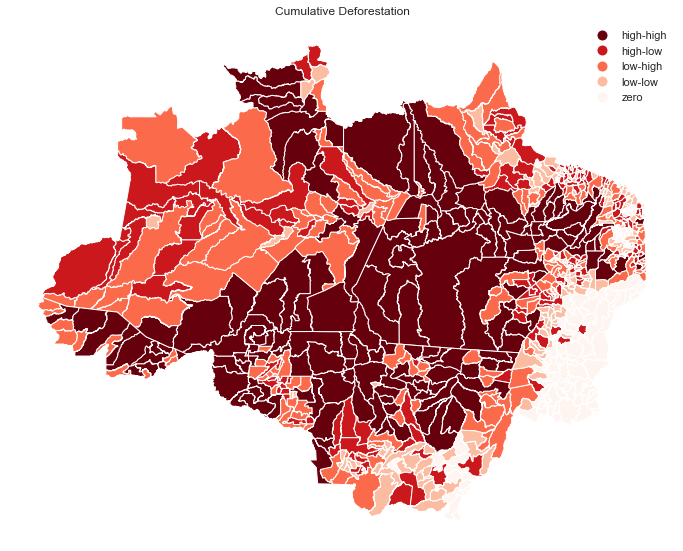

In [128]:
#Counties deforestation - quarter analysis

countie_map_def_acc.plot(column='def_acc_quartile', cmap='Reds_r', figsize=(12,12), legend=True).set_title('Cumulative Deforestation')

plt.axis('off') ;

#### 5.1.2.2 Agriculture

**Counties** that **doesn't have any deforestation** account for **almost 1/5 of total**. Therefore, **Counties** that **have dforestation** (4/5 of total) **were splitted in 4 parts** so the **classifications had ~20% each**. However, since **almost a 100% of Counties have some form of agriculture**, the **data will be divided in in 5 instead of 4**, so **each classification** has **~20% of data** and we can **visually compare** both of them 

In [129]:
#Calculate quintiles
agri_acc = df_countie[['agri_acc']]

agri_acc['agri_acc_quartile'] = 0
agri_acc.sort_values(by='agri_acc', ascending=False, inplace=True)
agri_acc['agri_acc_quartile'] = pd.qcut(agri_acc['agri_acc'], q=5, duplicates='drop')

In [130]:
#Remove special characters

agri_acc['agri_acc_quartile'] = agri_acc['agri_acc_quartile'].astype('str')
agri_acc['agri_acc_quartile'] = agri_acc['agri_acc_quartile'].str.replace('(','')
agri_acc['agri_acc_quartile'] = agri_acc['agri_acc_quartile'].str.replace(']','')

In [131]:
agri_acc['agri_acc_quartile'].unique()

array(['156163.0, 12240790.0', '53073.2, 156163.0', '24562.8, 53073.2',
       '10824.2, 24562.8', '-0.001, 10824.2'], dtype=object)

In [132]:
#Replace for classification

class_dict = {'156163.0, 12240790.0':'high-high','53073.2, 156163.0':'low-high','24562.8, 53073.2':'high-low','10824.2, 24562.8':'low-low', '-0.001, 10824.2':'zero (very low)'}              

agri_acc['agri_acc_quartile'] = agri_acc['agri_acc_quartile'].map(class_dict)

In [133]:
#Substitute few NaNs

agri_acc.fillna('zero (very low)', inplace=True)

In [134]:
#See distribution

agri_acc['agri_acc_quartile'].value_counts(normalize=True)*100

zero (very low)    20.077720
high-high          20.077720
low-high           19.948187
high-low           19.948187
low-low            19.948187
Name: agri_acc_quartile, dtype: float64

In [135]:
#Transform index

agri_acc.reset_index(inplace=True)
agri_acc['cod_ibge'] = agri_acc['cod_ibge'].astype('int')

In [136]:
#Merge with counties map database

countie_map_agri_acc = mun.merge(agri_acc, on='cod_ibge', how='left')

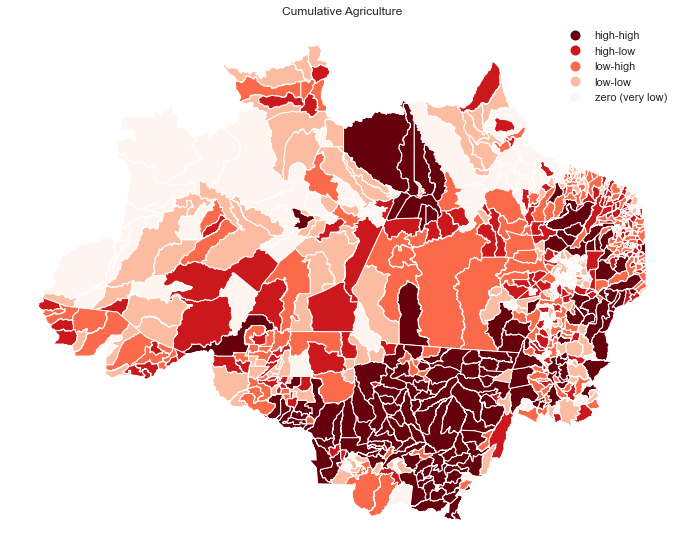

In [137]:
#Counties deforestation - quarter analysis

countie_map_agri_acc.plot(column='agri_acc_quartile', cmap='Reds_r', figsize=(12,12), legend=True).set_title('Cumulative Agriculture')

plt.axis('off') ;

#### 5.1.2.3 Cattle

Following the **same logic as Agriculture**, Cattle growing tendencies will also be **splitted in 5 parts** so each both graphs have the **same proportion of Counties in each class** to better visual comparison

In [138]:
#Calculate quintiles
cattle_acc = df_countie[['cattle_acc']]

cattle_acc['cattle_acc_quartile'] = 0
cattle_acc.sort_values(by='cattle_acc', ascending=False, inplace=True)
cattle_acc['cattle_acc_quartile'] = pd.qcut(cattle_acc['cattle_acc'], q=5, duplicates='drop')

In [139]:
#Remove special characters

cattle_acc['cattle_acc_quartile'] = cattle_acc['cattle_acc_quartile'].astype('str')
cattle_acc['cattle_acc_quartile'] = cattle_acc['cattle_acc_quartile'].str.replace('(','')
cattle_acc['cattle_acc_quartile'] = cattle_acc['cattle_acc_quartile'].str.replace(']','')

In [140]:
cattle_acc['cattle_acc_quartile'].unique()

array(['1915923.4, 25650540.0', '873481.4, 1915923.4',
       '356474.0, 873481.4', '133388.0, 356474.0', '205.999, 133388.0'],
      dtype=object)

In [141]:
#Replace for classification

class_dict = {'1915923.4, 25650540.0':'high-high','873481.4, 1915923.4':'low-high','356474.0, 873481.4':'high-low','133388.0, 356474.0':'low-low', '205.999, 133388.0':'zero (very low)'}              

cattle_acc['cattle_acc_quartile'] = cattle_acc['cattle_acc_quartile'].map(class_dict)

In [142]:
#See distribution

cattle_acc['cattle_acc_quartile'].value_counts(normalize=True)*100

zero (very low)    20.077720
high-high          20.077720
low-high           19.948187
high-low           19.948187
low-low            19.948187
Name: cattle_acc_quartile, dtype: float64

In [143]:
#Transform index

cattle_acc.reset_index(inplace=True)
cattle_acc['cod_ibge'] = cattle_acc['cod_ibge'].astype('int')

In [144]:
#Merge with counties map database

countie_map_cattle_acc = mun.merge(cattle_acc, on='cod_ibge', how='left')

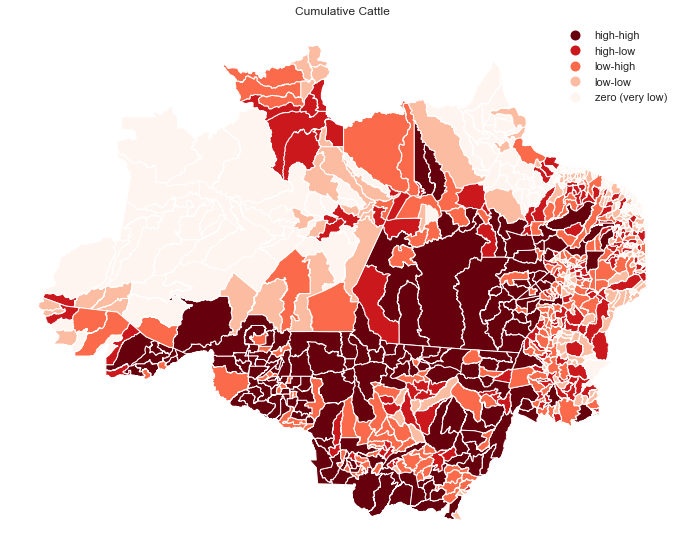

In [145]:
#Counties deforestation - quarter analysis

countie_map_cattle_acc.plot(column='cattle_acc_quartile', cmap='Reds_r', figsize=(12,12), legend=True).set_title('Cumulative Cattle')

plt.axis('off') ;

## 5.2 Multivariate descriptive analysis

The **correlation analysis** is important to get a **feeling about which features** are later going to be considered **relevant by the algorithms**
Features that demonstrated some **correlation** with **cumulative deforestation** (*target variable*):

**cattle_acc**: cumulative cattle demonstrated an **impressive correlation of 0.57** with cumulative deforestation while the **agriculture cumulative data indicated only 0.015 correlation**, this relevance will be **further confirmed** by the **Machine Learning algorithms**  

**area_countie**: has a positive correlation of 0.52. It makes sense that **big areas** have bigger cumulative deforestation **since there are more area to deforest**; once we are aiming to predict external and not intrinsecal characteristics, **this feature will not be in the Machine Learning modelling**. However, **it is interesing that cumulative cattle has bigger correlation with cumulative deforestation even than the area of the Counties**

**HDI_educacao**: it is also intriguing that **Education Human Development Index** demonstrated a **negative correlation with cumulative deforestation of -0.14**. This is interesting and **will also be confirmed** with the **Machine Learning Modelling**

Since **cumulative cattle** has the **biggest correlation** with the target variable, it's worth to **highlight the greates cattle correlation** features besides deforestation: 

**IDHM_longevidade**: positve correlation of **0.4**. It is interesting that **the other two fetaures are also related with Human Development Index variables**

**IDHM_renda**: positive correlation of **0.31**  

**IDHM**: positive correlation of **0.25** 

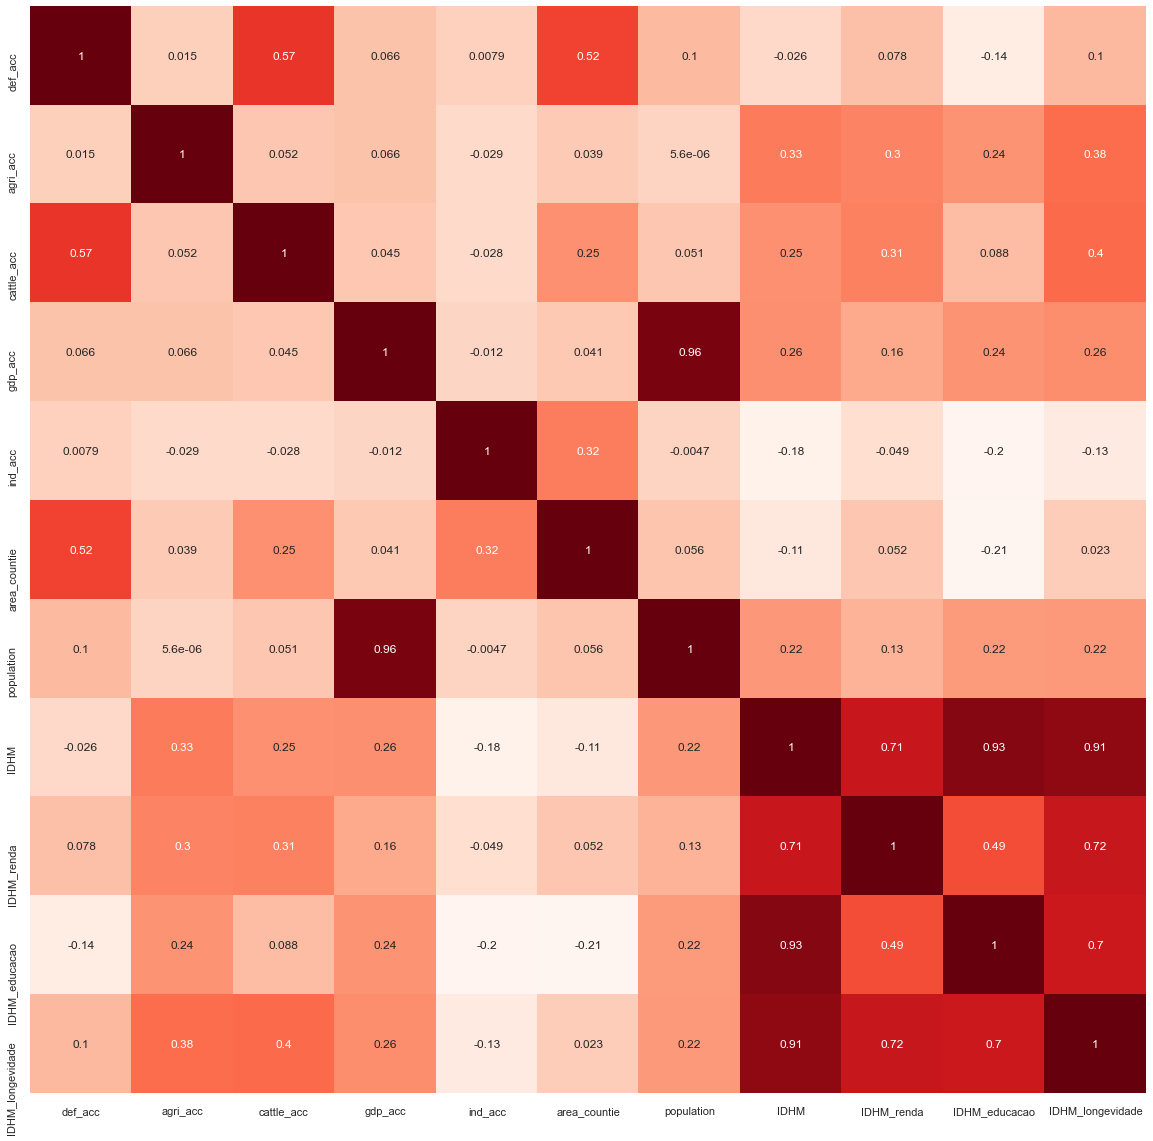

In [146]:
#Correlation analysis

df_corr = df_countie.copy()

correlation = df_corr.corr(method='pearson')

plt.rcParams['figure.figsize'] = [20, 20]
sns.heatmap(correlation, annot=True, cmap='Reds', cbar=False) ;

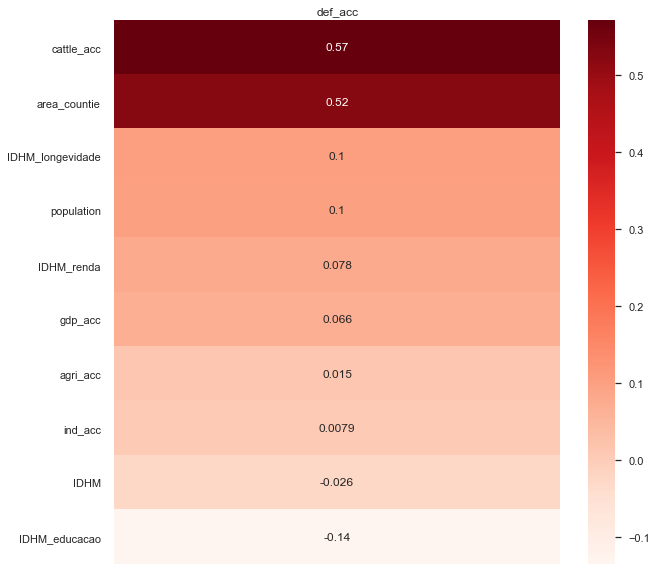

In [147]:
#See correlations of Deforestation - target variable
plt.rcParams['figure.figsize'] = [10, 10]

plot_corr('def_acc') ;          #see more details in helper functions 

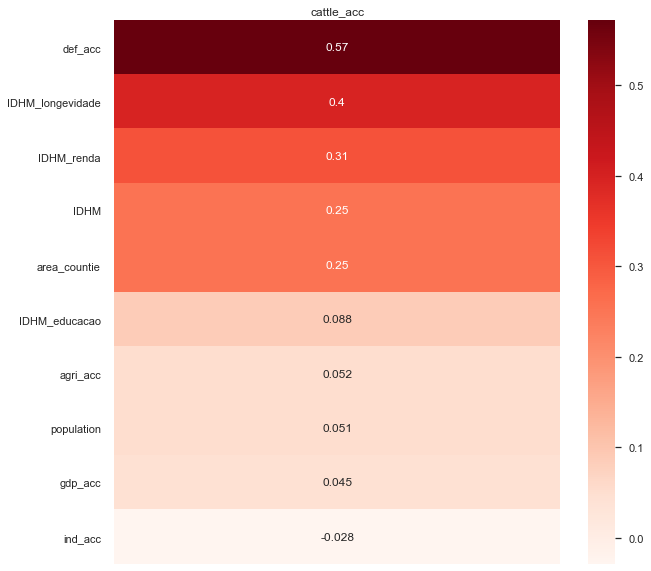

In [148]:
#See correlations of cumulative Cattle 
plt.rcParams['figure.figsize'] = [10, 10]

plot_corr('cattle_acc') ;       #see more details in helper functions 

## 5.3 Hypothesis driven analysis 

### 5.3.1 Hypothesis creation 

<img src="files/mindmap2.png" width="9000">


**Deforestation** x **Rural industry**

- **H1.** **More** than **1/2 of Counties** classified as **high-high** cumulative **deforestation** and **agriculture** are shared 

- **H2.** **More** than **1/2 of Counties** classified as **high-high** cumulative **deforestation** and **cattle** are shared 

**Deforestation** x **Social & Economic**

- **H3.** **More** than **1/2 of Counties** classified as **high-high** cumulative **deforestation** and **gdp** are shared

- **H4.** **More** than **1/2 of Counties** classified as **high-high** cumulative **deforestation** and **Education HDI** are shared 

**Rural Industry x Social & Economic**

- **H5.** **More** than **1/2 of Counties** classified as **high-high** cumulative **agriculture** and **gdp** are shared 

- **H6.** **More** than **1/2 of Counties** classified as **high-high** cumulative **cattle** and **gdp** are shared 

**Deforestation x Legal Protected areas**

- **H7.** **More** than **1/2 of Counties** classified as **high-high** cumulative **deforestation** and **indigenous areas** are shared

**Rural industry x Legal Protected areas**

- **H8.** **More** than **1/2 of Counties** that have deforestation in **indigenous areas** and high-high cumulative **agriculture** are shared

- **H9.** **More** than **1/2 of Counties** that have deforestation in **indigenous areas** and high-high cumulative **cattle** are shared

**Deforestation x Characteristics**

- **H10.** **More** than **1/2 of Counties** classified as **high-high** in **area** and **cumulative deforestation** are shared

- **H11.** **More** than **1/2 of Counties** classified as **high-high** in **population density** and **cumulative deforestation** are shared


### 5.3.2 Hypothesis validation

#### **H1.** **More** than **1/2 of Counties** classified as **high-high** cumulative **deforestation** and **agriculture** are shared  

**FALSE**: Nearly **~38% share** of cumulative **deforestation** and **agriculture**

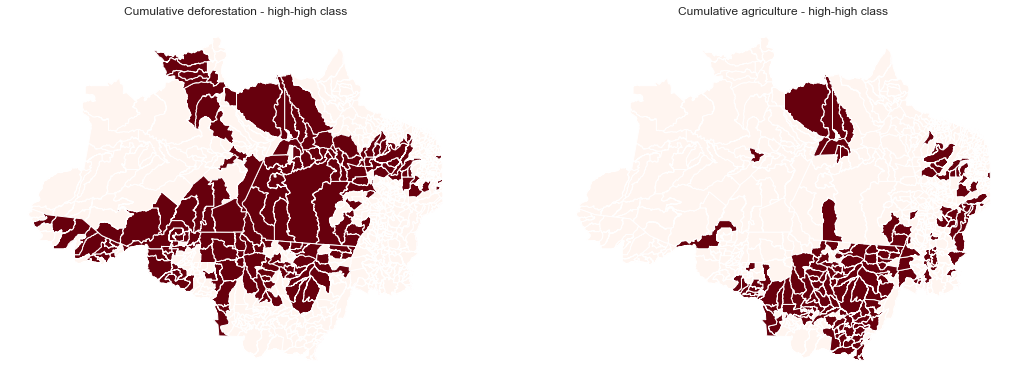

In [461]:
#Comparison - high-high classification
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(18,8))

plt.rcParams['figure.figsize'] = [20, 10]
high_countie_map_def = countie_map_def_acc.copy()
high_countie_map_def['def_acc_quartile'] = high_countie_map_def['def_acc_quartile'].apply(lambda x: 'high-high' if x=='high-high' else '-')
high_countie_map_def.plot(column='def_acc_quartile', cmap='Reds', ax=ax1, figsize=(20,12), legend=False) 
ax1.axis('off')
ax1.set_title('Cumulative deforestation - high-high class') 

high_countie_map_agri = countie_map_agri_acc.copy()
high_countie_map_agri['agri_acc_quartile'] = high_countie_map_agri['agri_acc_quartile'].apply(lambda x: 'high-high' if x=='high-high' else '-')
high_countie_map_agri.fillna(0, inplace=True)
high_countie_map_agri.plot(column='agri_acc_quartile', cmap='Reds', ax=ax2, figsize=(20,12), legend=False) 
ax2.axis('off')
ax2.set_title('Cumulative agriculture - high-high class') ;

In [150]:
#Select only high-high deforestation slope

high_def = def_acc_countie_quarter[def_acc_countie_quarter['def_acc_quartile'] == 'high-high']

def_size = len(high_def)
def_size

159

In [151]:
#Select only high-high agriculture slope

high_agri = agri_acc[agri_acc['agri_acc_quartile'] == 'high-high']

size_agri = len(high_agri)
size_agri

155

In [152]:
#Inner join to see Counties in common

shared_def_agri = high_def.merge(high_agri, on='cod_ibge', how='inner')

size_shared_def_agri = len(shared_def_agri) 

(size_shared_def_agri / size_agri ) * 100

37.41935483870968

In [153]:
#Merge with counties map database

shared_map_def_agri = mun.merge(shared_def_agri, on='cod_ibge', how='left')
shared_map_def_agri.fillna('-', inplace=True)

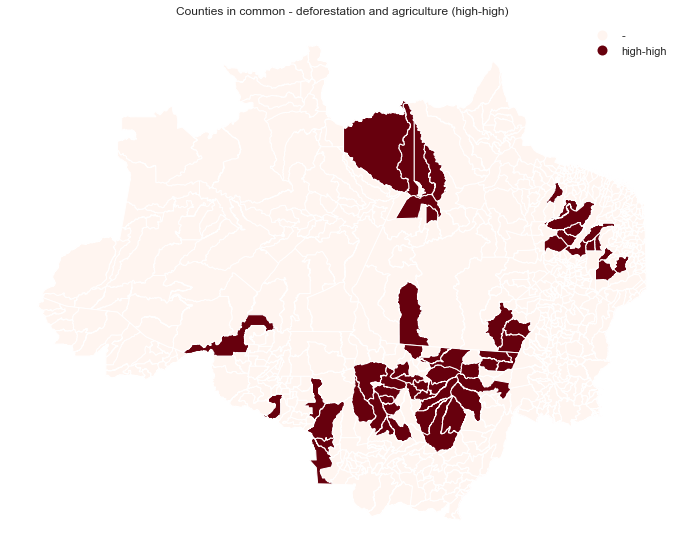

In [154]:
#Visualize result

shared_map_def_agri.plot(column='agri_acc_quartile', cmap='Reds', figsize=(12,12), legend=True).set_title('Counties in common - deforestation and agriculture (high-high)')
plt.axis('off') ;

#### **H2.** **More** than **1/2 of Counties** classified as **high-high** cumulative **deforestation** and **cattle** are shared  
**TRUE**: Nearly **~52% share** of cumulative **deforestation** and **cattle**. We can also see **visually** that the **Counties are in similar regions**

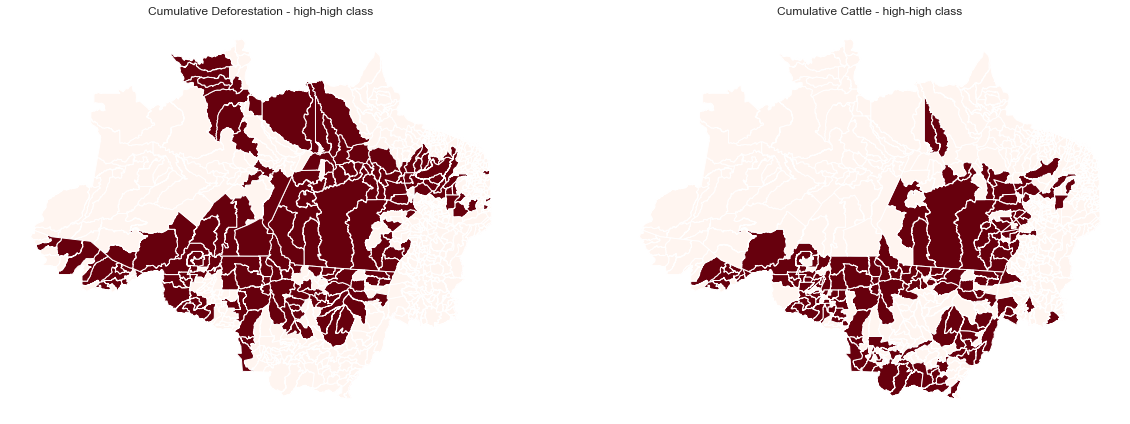

In [155]:
#Comparison - high-high classification
fig, (ax1, ax2)= plt.subplots(1,2)

high_countie_map_def.plot(column='def_acc_quartile', cmap='Reds', ax=ax1) 
ax1.axis('off')
ax1.set_title('Cumulative Deforestation - high-high class') 

high_countie_map_cattle = countie_map_cattle_acc.copy()
high_countie_map_cattle['cattle_acc_quartile'] = high_countie_map_cattle['cattle_acc_quartile'].apply(lambda x: 'high-high' if x=='high-high' else '-')
high_countie_map_cattle.fillna(0, inplace=True)
high_countie_map_cattle.plot(column='cattle_acc_quartile', cmap='Reds', ax=ax2) 
ax2.axis('off')
ax2.set_title('Cumulative Cattle - high-high class') ;

In [156]:
#Select only high-high deforestation slope

len(high_def)

159

In [157]:
#Select only high-high agriculture slope

high_cattle = cattle_acc[cattle_acc['cattle_acc_quartile'] == 'high-high']

size_cattle = len(high_cattle)
size_cattle

155

In [158]:
#Inner join to see Counties in common

shared_def_cattle = high_def.merge(high_cattle, on='cod_ibge', how='inner')

size_shared_def_cattle = len(shared_def_cattle) 

(size_shared_def_cattle / size_cattle) * 100

51.61290322580645

In [159]:
#Merge with counties map database

shared_map_def_cattle = mun.merge(shared_def_cattle, on='cod_ibge', how='left')
shared_map_def_cattle.fillna('-', inplace=True)

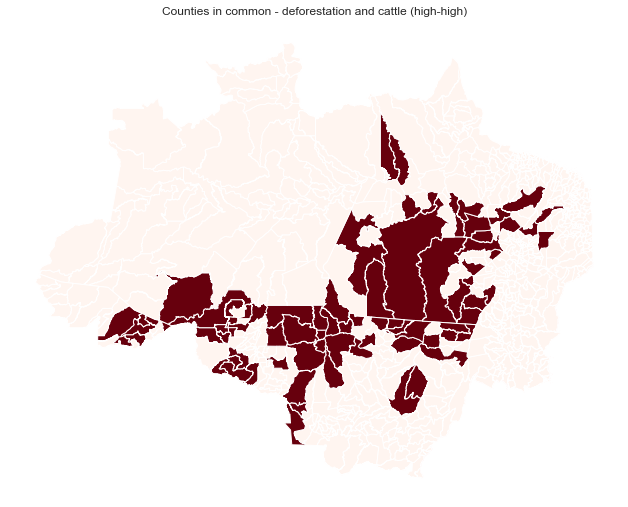

In [160]:
#Visualize result

shared_map_def_cattle.plot(column='cattle_acc_quartile', cmap='Reds', figsize=(11,11)).set_title('Counties in common - deforestation and cattle (high-high)')
plt.axis('off') ;

#### **H3.** **More** than **1/2 of Counties** classified as **high-high** cumulative **deforestation** and **gdp** are shared

**FALSE**: Nearly ~40% of cumulative **deforestation** and **gdp** are shared

In [161]:
#Calculate quarters
gdp_quarter = df_countie.copy()

gdp_quarter['gdp_acc_quartile'] = 0
gdp_quarter.sort_values(by='gdp_acc', ascending=False, inplace=True)
gdp_quarter['gdp_acc_quartile'] = pd.qcut(gdp_quarter['gdp_acc'], q=5, duplicates='drop')

In [162]:
#Remove special characters

gdp_quarter['gdp_acc_quartile'] = gdp_quarter['gdp_acc_quartile'].astype('str')
gdp_quarter['gdp_acc_quartile'] = gdp_quarter['gdp_acc_quartile'].str.replace('(','')
gdp_quarter['gdp_acc_quartile'] = gdp_quarter['gdp_acc_quartile'].str.replace(']','')

In [163]:
gdp_quarter['gdp_acc_quartile'].unique()

array(['4836240.4, 741181105.0', '2342185.2, 4836240.4',
       '1281693.2, 2342185.2', '688687.2, 1281693.2',
       '177096.999, 688687.2'], dtype=object)

In [164]:
#Replace for classification

class_dict = {'4836240.4, 741181105.0':'high-high','2342185.2, 4836240.4':'low-high','1281693.2, 2342185.2':'high-low','688687.2, 1281693.2':'low-low','177096.999, 688687.2':'zero (very low)'}

gdp_quarter['gdp_acc_quartile'] = gdp_quarter['gdp_acc_quartile'].map(class_dict)

In [165]:
#See distribution

gdp_quarter['gdp_acc_quartile'].value_counts(normalize=True)*100

zero (very low)    20.077720
high-high          20.077720
low-high           19.948187
high-low           19.948187
low-low            19.948187
Name: gdp_acc_quartile, dtype: float64

In [166]:
#Transform index

gdp_quarter.reset_index(inplace=True)
gdp_quarter['cod_ibge'] = gdp_quarter['cod_ibge'].astype('int')

In [167]:
#Merge with counties map database

countie_map_gdp = mun.merge(gdp_quarter, on='cod_ibge', how='left')

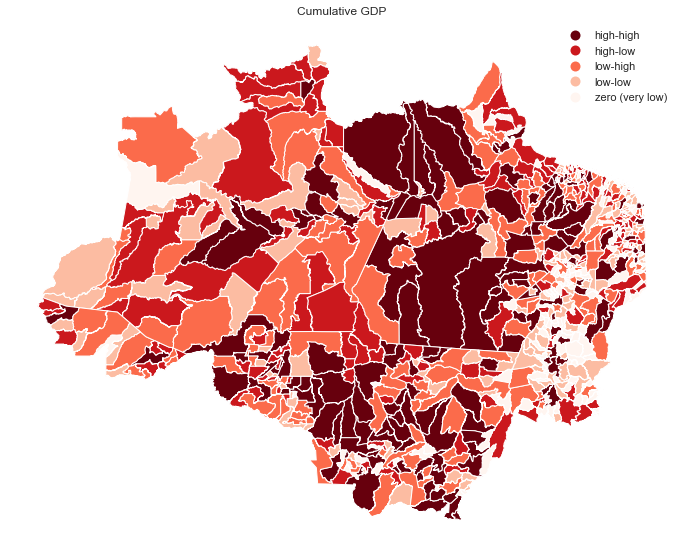

In [168]:
#Plot GDP growing tendencies

countie_map_gdp.plot(column='gdp_acc_quartile', cmap='Reds_r', figsize=(12,12), legend=True).set_title('Cumulative GDP') 
plt.axis('off') ;

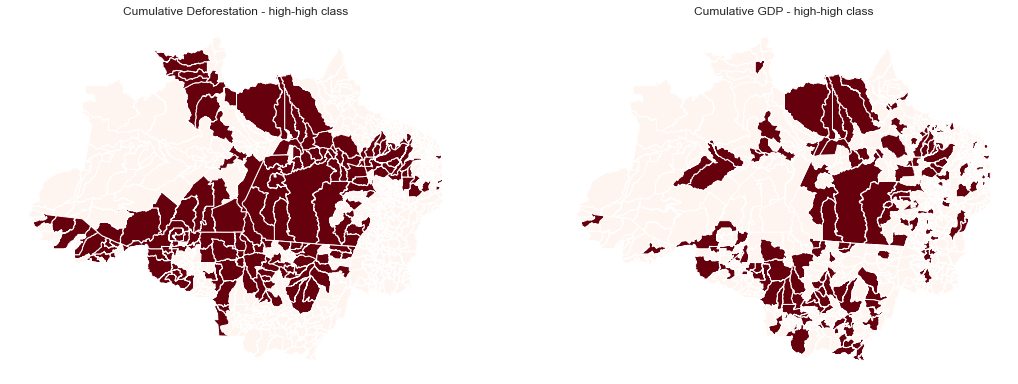

In [432]:
#Comparison - high-high classification
fig, (ax1, ax2)= plt.subplots(1,2)

high_countie_map_def.plot(column='def_acc_quartile', cmap='Reds', ax=ax1) 
ax1.axis('off')
ax1.set_title('Cumulative Deforestation - high-high class') 

high_countie_map_gdp = countie_map_gdp.copy()
high_countie_map_gdp['gdp_acc_quartile'] = high_countie_map_gdp['gdp_acc_quartile'].apply(lambda x: 'high-high' if x=='high-high' else '-')
high_countie_map_gdp.fillna(0, inplace=True)
high_countie_map_gdp.plot(column='gdp_acc_quartile', cmap='Reds', ax=ax2) 
ax2.axis('off')
ax2.set_title('Cumulative GDP - high-high class') ;

In [170]:
#Select only high-high GDP slope

high_gdp = gdp_quarter[gdp_quarter['gdp_acc_quartile'] == 'high-high']

size_gdp = len(high_gdp)
size_gdp

155

In [171]:
#Inner join to see Counties in common

shared_def_gdp = high_def.merge(high_gdp, on='cod_ibge', how='inner')

size_shared_def_gdp = len(shared_def_gdp) 

(size_shared_def_gdp / size_gdp) * 100

39.35483870967742

In [172]:
#Merge with counties map database

shared_map_def_gdp = mun.merge(shared_def_gdp, on='cod_ibge', how='left')
shared_map_def_gdp.fillna('-', inplace=True)

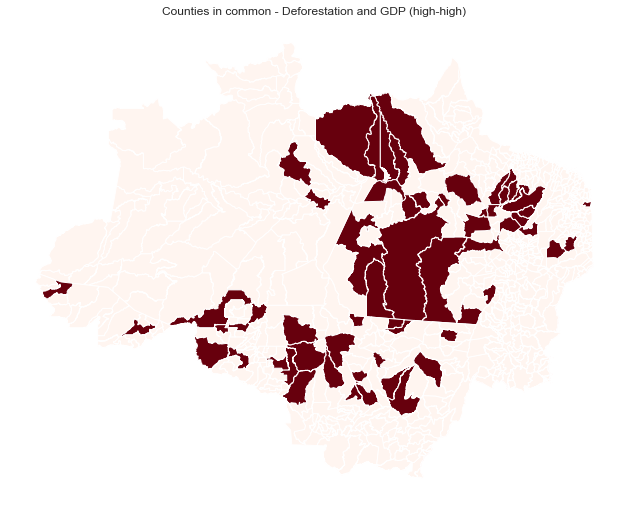

In [442]:
#Visualize result

shared_map_def_gdp.plot(column='gdp_acc_quartile', cmap='Reds', figsize=(11,11)).set_title('Counties in common - Deforestation and GDP (high-high)')
plt.axis('off') ;

#### **H4.** **More** than **1/2 of Counties** classified as cumulative **deforestation** and zero (very low) **Education HDI** are shared 

**FALSE**: Nearly ~33% of share of cumulative **deforestation** and **Education HDI classification** of zero (very low) class 

In [444]:
#Calculate quarters
hdi_quarter = df_countie.copy()

hdi_quarter['ed_hdi_quartile'] = 0
hdi_quarter.sort_values(by='IDHM_educacao', ascending=False, inplace=True)
hdi_quarter['ed_hdi_quartile'] = pd.qcut(hdi_quarter['IDHM_educacao'], q=5, duplicates='drop')

In [445]:
#Remove special characters

hdi_quarter['ed_hdi_quartile'] = hdi_quarter['ed_hdi_quartile'].astype('str')
hdi_quarter['ed_hdi_quartile'] = hdi_quarter['ed_hdi_quartile'].str.replace('(','')
hdi_quarter['ed_hdi_quartile'] = hdi_quarter['ed_hdi_quartile'].str.replace(']','')

In [446]:
hdi_quarter['ed_hdi_quartile'].unique()

array(['0.58, 0.752', '0.533, 0.58', '0.486, 0.533', '0.437, 0.486',
       '0.206, 0.437'], dtype=object)

In [447]:
#Replace for classification

class_dict = {'0.58, 0.752':'high-high','0.533, 0.58':'low-high','0.486, 0.533':'high-low','0.437, 0.486':'low-low','0.206, 0.437':'zero (very low)'}

hdi_quarter['ed_hdi_quartile'] = hdi_quarter['ed_hdi_quartile'].map(class_dict)

In [448]:
#See distribution

hdi_quarter['ed_hdi_quartile'].value_counts(normalize=True)*100

zero (very low)    20.336788
high-high          20.077720
low-high           19.948187
high-low           19.818653
low-low            19.818653
Name: ed_hdi_quartile, dtype: float64

In [449]:
#Transform index

hdi_quarter.reset_index(inplace=True)
hdi_quarter['cod_ibge'] = hdi_quarter['cod_ibge'].astype('int')

In [450]:
#Merge with counties map database

countie_map_hdi = mun.merge(hdi_quarter, on='cod_ibge', how='left')

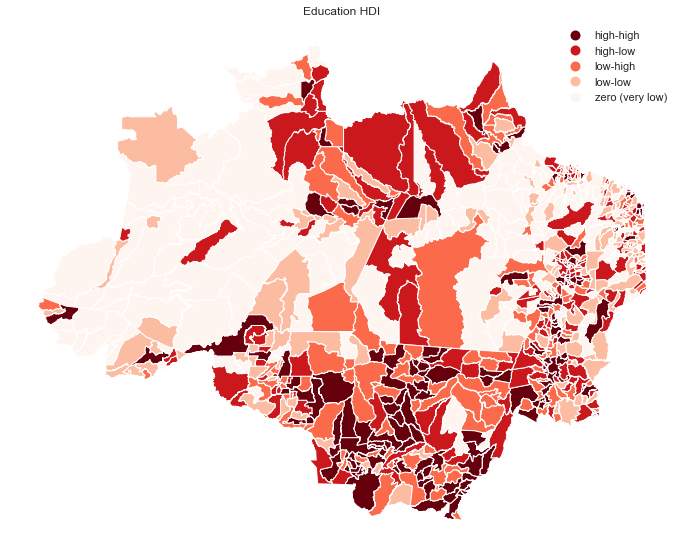

In [451]:
#Plot GDP growing tendencies

countie_map_hdi.plot(column='ed_hdi_quartile', cmap='Reds_r', figsize=(12,12), legend=True).set_title('Education HDI') 
plt.axis('off') ;

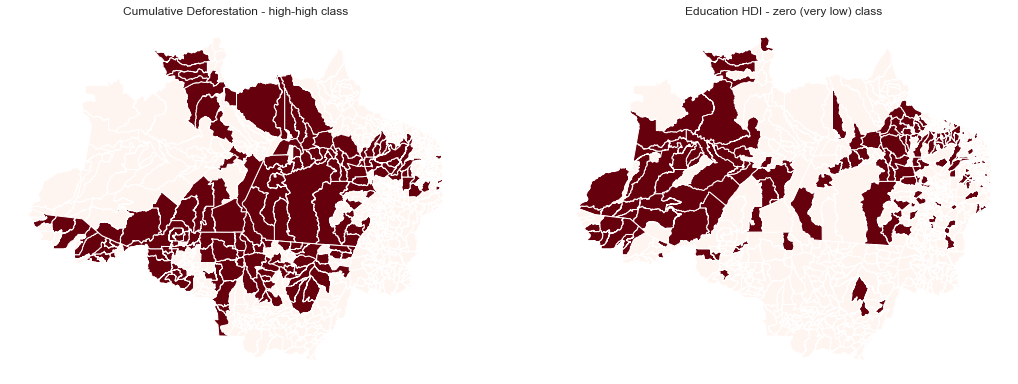

In [454]:
#Comparison - high-high classification
fig, (ax1, ax2)= plt.subplots(1,2)

high_countie_map_def.plot(column='def_acc_quartile', cmap='Reds', ax=ax1) 
ax1.axis('off')
ax1.set_title('Cumulative Deforestation - high-high class') 

high_countie_map_hdi = countie_map_hdi.copy()
high_countie_map_hdi['ed_hdi_quartile'] = high_countie_map_hdi['ed_hdi_quartile'].apply(lambda x: 'zero (very low)' if x=='zero (very low)' else '-')
high_countie_map_hdi.fillna(0, inplace=True)
high_countie_map_hdi.plot(column='ed_hdi_quartile', cmap='Reds', ax=ax2) 
ax2.axis('off')
ax2.set_title('Education HDI - zero (very low) class') ;

In [456]:
#Select only high-high GDP slope

low_hdi = hdi_quarter[hdi_quarter['ed_hdi_quartile'] == 'zero (very low)']

size_hdi = len(low_hdi)
size_hdi

157

In [460]:
#Inner join to see Counties in common

shared_def_hdi = high_def.merge(low_hdi, on='cod_ibge', how='inner')

size_shared_def_hdi = len(shared_def_hdi) 

(size_shared_def_hdi / size_hdi) * 100

32.48407643312102

In [172]:
#Merge with counties map database

shared_map_def_gdp = mun.merge(shared_def_gdp, on='cod_ibge', how='left')
shared_map_def_gdp.fillna('-', inplace=True)

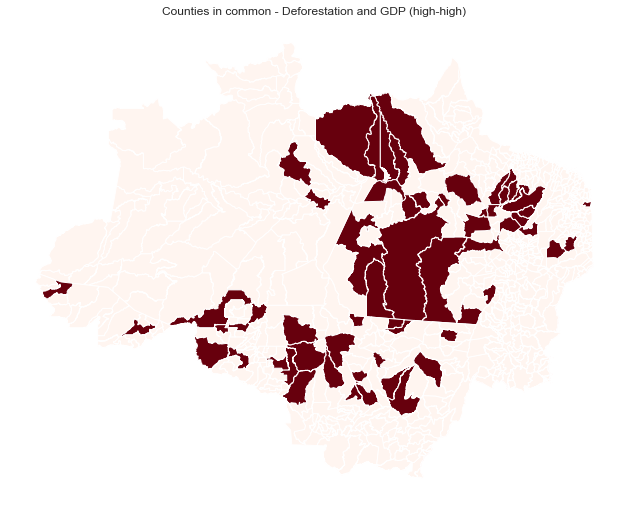

In [442]:
#Visualize result

shared_map_def_gdp.plot(column='gdp_acc_quartile', cmap='Reds', figsize=(11,11)).set_title('Counties in common - Deforestation and GDP (high-high)')
plt.axis('off') ;

#### **H5**. **More** than **1/2 of Counties** classified as **high-high** cumulative **agriculture** and **gdp** are shared 

**FALSE**: Nearly **~44% share** of Counties with cumulative in **agriculture** and **gdp**

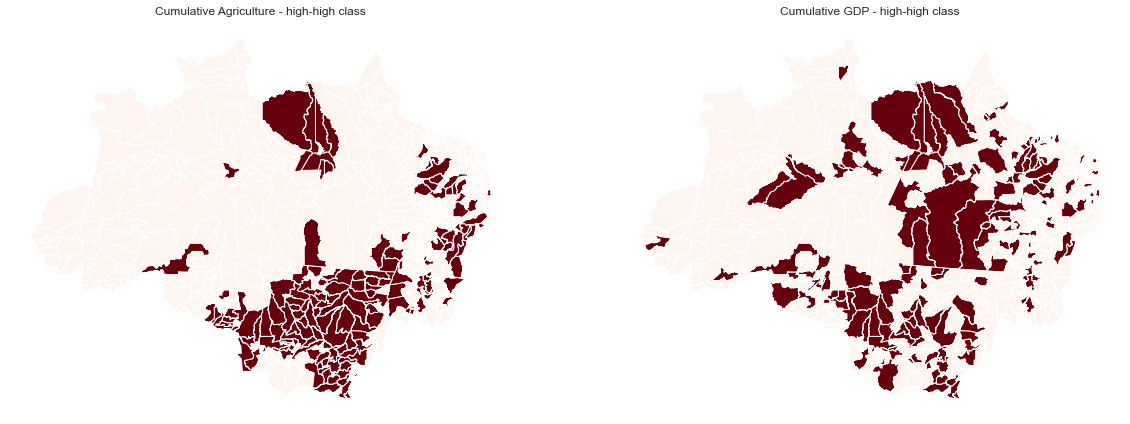

In [169]:
#Comparison - high-high classification
fig, (ax1, ax2)= plt.subplots(1,2)

high_countie_map_agri.plot(column='agri_acc_quartile', cmap='Reds', ax=ax1) 
ax1.axis('off')
ax1.set_title('Cumulative Agriculture - high-high class') ;

high_countie_map_gdp = countie_map_gdp.copy()
high_countie_map_gdp['gdp_acc_quartile'] = high_countie_map_gdp['gdp_acc_quartile'].apply(lambda x: 'high-high' if x=='high-high' else '-')
high_countie_map_gdp.fillna(0, inplace=True)
high_countie_map_gdp.plot(column='gdp_acc_quartile', cmap='Reds', ax=ax2) 
ax2.axis('off')
ax2.set_title('Cumulative GDP - high-high class') ;

In [170]:
#Select only high-high GDP slope

high_gdp = gdp_quarter[gdp_quarter['gdp_acc_quartile'] == 'high-high']

size_gdp = len(high_gdp)
size_gdp

155

In [434]:
#Inner join to see Counties in common

shared_agri_gdp = high_agri.merge(high_gdp, on='cod_ibge', how='inner')

size_shared_agri_gdp = len(shared_agri_gdp) 

(size_shared_agri_gdp / size_gdp) * 100

43.87096774193549

In [435]:
#Merge with counties map database

shared_map_agri_gdp = mun.merge(shared_agri_gdp, on='cod_ibge', how='left')
shared_map_agri_gdp.fillna('-', inplace=True)

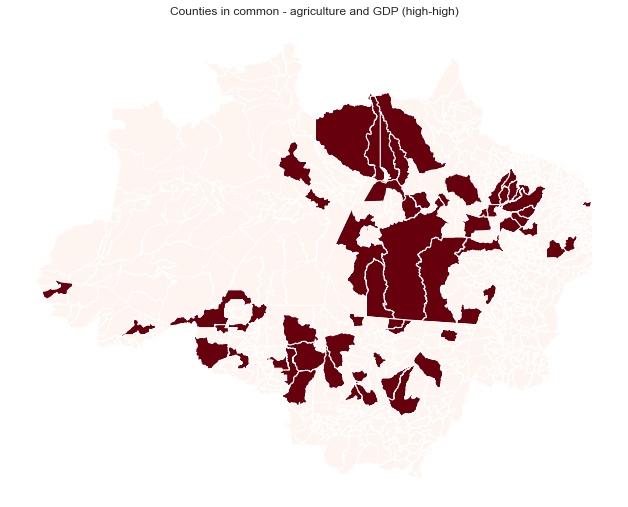

In [437]:
#Visualize result

shared_map_def_gdp.plot(column='gdp_acc_quartile', cmap='Reds', figsize=(11,11)).set_title('Counties in common - agriculture and GDP (high-high)')
plt.axis('off') ;

#### **H6.** **More** than **1/2 of Counties** classified as **high-high** cumulative **cattle** and **gdp** are shared 

**FALSE**: Nearly **~39% share** of Counties with cumulative in **cattle** and **gdp**

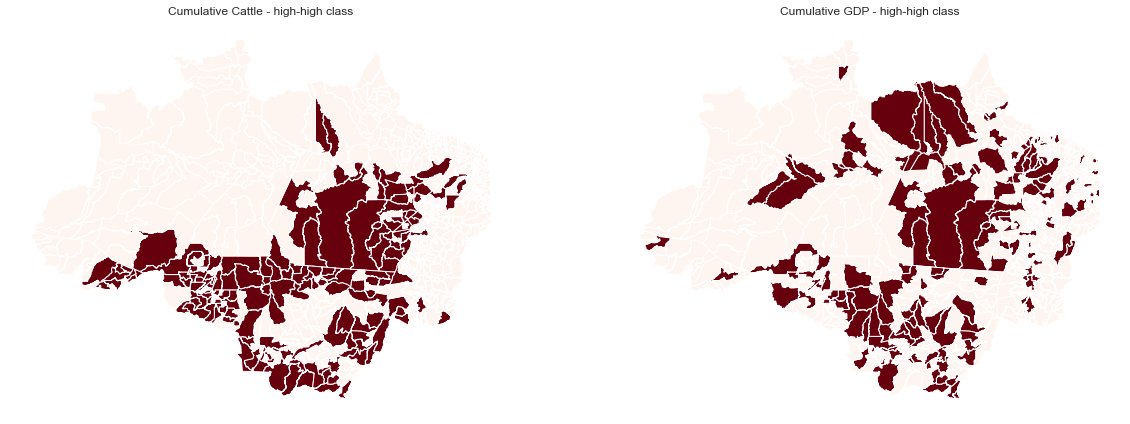

In [174]:
#Comparison - high-high classification
fig, (ax1, ax2)= plt.subplots(1,2)

high_countie_map_cattle.plot(column='cattle_acc_quartile', cmap='Reds', ax=ax1) 
ax1.axis('off')
ax1.set_title('Cumulative Cattle - high-high class') ;

high_countie_map_gdp = countie_map_gdp.copy()
high_countie_map_gdp['gdp_acc_quartile'] = high_countie_map_gdp['gdp_acc_quartile'].apply(lambda x: 'high-high' if x=='high-high' else '-')
high_countie_map_gdp.fillna(0, inplace=True)
high_countie_map_gdp.plot(column='gdp_acc_quartile', cmap='Reds', ax=ax2) 
ax2.axis('off')
ax2.set_title('Cumulative GDP - high-high class') ;

In [175]:
#Inner join to see Counties in common

shared_cattle_gdp = high_cattle.merge(high_gdp, on='cod_ibge', how='inner')

size_shared_cattle_gdp = len(shared_cattle_gdp) 

(size_shared_cattle_gdp / size_gdp) * 100

38.70967741935484

In [440]:
#Merge with counties map database

shared_map_cattle_gdp = mun.merge(shared_cattle_gdp, on='cod_ibge', how='left')
shared_map_cattle_gdp.fillna('-', inplace=True)

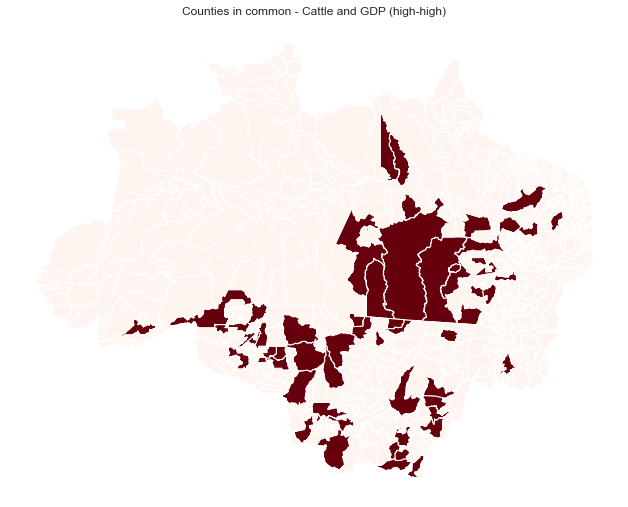

In [441]:
#Visualize result

shared_map_cattle_gdp.plot(column='gdp_acc_quartile', cmap='Reds', figsize=(11,11)).set_title('Counties in common - Cattle and GDP (high-high)')
plt.axis('off') ;

#### **H7.** **More** than **1/2 of Counties** classified as **high-high** cumulative **deforestation** and **indigenous areas** are shared

Since counties that have **deforestation in indigenous areas accounts for only ~25% of total**, they are **not going to be classified** and **all of them** will be used to see **how much there are in common with high-high deforestation** classification

**TRUE**: it is interesting that nearly **~60%** of the Counties that have deforestation in indigenous areas are shared with Counties with high-high cumulative in **deforestation**. Visually, we can see a **lot of similarity between both of them**

In [182]:
#Proportion of deforestation in indigenous areas

ind_not_zero = ind_acc_countie[ind_acc_countie['ind_acc'] != 0]

len(ind_not_zero) / len(ind_acc_countie)

0.26424870466321243

In [184]:
#Transform index

ind_acc_countie.reset_index(inplace=True)
ind_acc_countie['cod_ibge'] = ind_acc_countie['cod_ibge'].astype('int')

In [185]:
#Merge into geodataframe

ind_map = mun.merge(ind_acc_countie, on='cod_ibge', how='left')
ind_map.fillna('-', inplace=True)

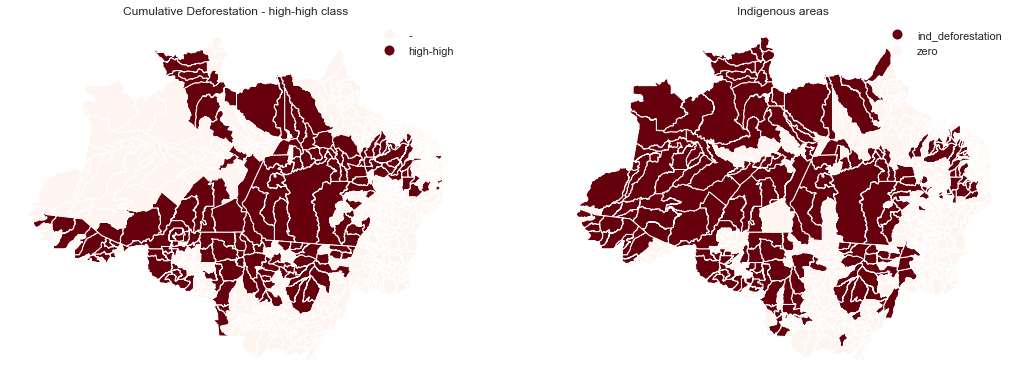

In [188]:
#Comparison - high-high classification
plt.rcParams['figure.figsize'] = [18, 10]
fig, (ax1, ax2)= plt.subplots(1,2)
high_countie_map_def.plot(column='def_acc_quartile', cmap='Reds', ax=ax1, legend=True) 
ax1.axis('off')
ax1.set_title('Cumulative Deforestation - high-high class') 

ind_class = ind_map.copy()
ind_class['ind_class'] = ind_class['ind_acc'].apply(lambda x: 'zero' if x==0 else 'ind_deforestation')
ind_class.fillna(0, inplace=True)
ind_class.plot(column='ind_class', cmap='Reds_r', ax=ax2, legend=True) 
ax2.axis('off')
ax2.set_title('Indigenous areas') ;

In [190]:
#Inner join to see Counties in common

ind_not_zero.reset_index(inplace=True)
ind_not_zero['cod_ibge'] = ind_not_zero['cod_ibge'].astype('int')

ind_not_zero['ind_class'] = ind_not_zero['ind_acc'].apply(lambda x: 'zero' if x==0 else 'ind_deforestation')
ind_not_zero.fillna(0, inplace=True)

shared_def_ind = high_def.merge(ind_not_zero, on='cod_ibge', how='inner')

size_ind = len(shared_def_ind)

(size_ind / def_size)*100

59.74842767295597

In [191]:
#Merge with counties map database

shared_map_def_ind = mun.merge(shared_def_ind, on='cod_ibge', how='left')
shared_map_def_ind.fillna('-', inplace=True)

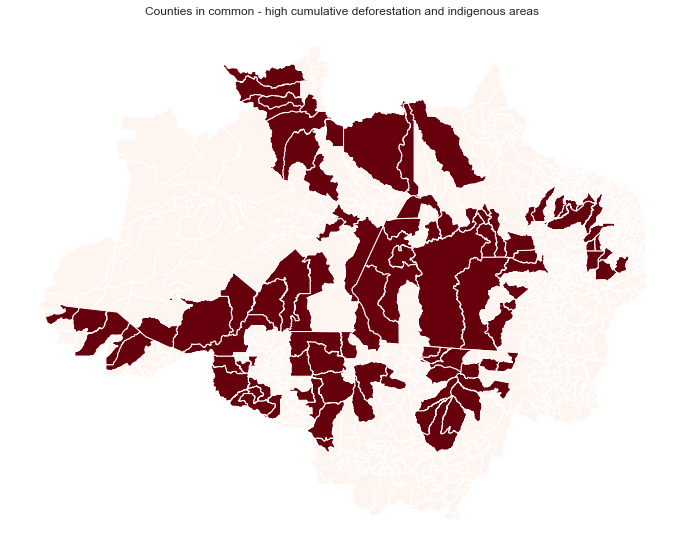

In [192]:
#Visualize result

shared_map_def_ind.plot(column='ind_class', cmap='Reds', figsize=(12,12)).set_title('Counties in common - high cumulative deforestation and indigenous areas')
plt.axis('off') ;

#### **H8.** **More** than **1/2 of Counties** that have deforestation in **indigenous areas** and high-high cumulative **agriculture** are shared

**FALSE**: Nearly **~34% of them** share high cumulative **agriculture** Counties and deforestation in **indigenous areas**

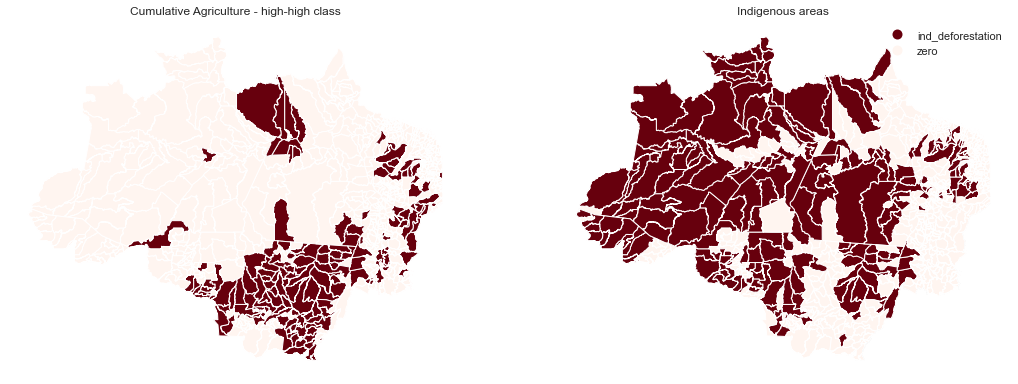

In [194]:
#Comparison - high-high classification
plt.rcParams['figure.figsize'] = [18, 10]
fig, (ax1, ax2)= plt.subplots(1,2)
high_countie_map_agri.plot(column='agri_acc_quartile', cmap='Reds', ax=ax1) 
ax1.axis('off')
ax1.set_title('Cumulative Agriculture - high-high class') 

ind_class.plot(column='ind_class', cmap='Reds_r', ax=ax2, legend=True) 
ax2.axis('off')
ax2.set_title('Indigenous areas') ;

In [195]:
#Inner join to see Counties in common

shared_agri_ind = high_agri.merge(ind_not_zero, on='cod_ibge', how='inner')

size_agri_ind = len(shared_agri_ind)

(size_agri_ind / size_agri)*100

33.5483870967742

In [196]:
#Merge with counties map database

shared_map_agri_ind = mun.merge(shared_agri_ind, on='cod_ibge', how='left')
shared_map_agri_ind.fillna('-', inplace=True)

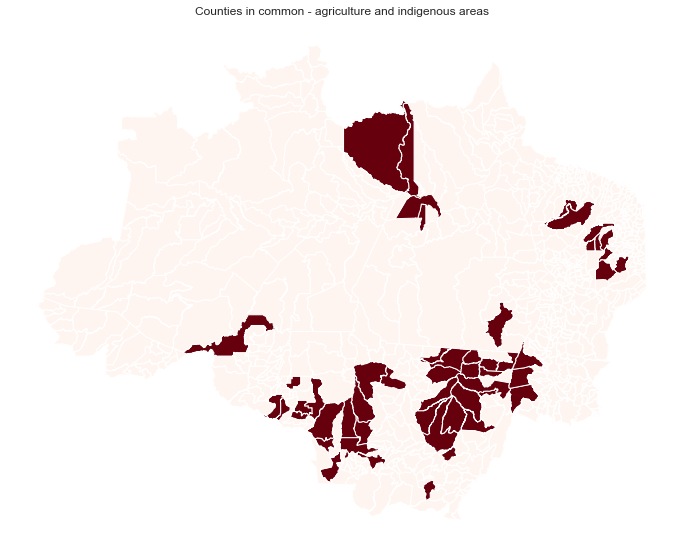

In [198]:
#Visualize result

shared_map_agri_ind.plot(column='ind_class', cmap='Reds', figsize=(12,12)).set_title('Counties in common - agriculture and indigenous areas')
plt.axis('off') ;

#### **H9.** **More** than **1/2 of Counties** that have deforestation in **indigenous areas** and high-high cumulative  **cattle** are shared

**FALSE**: different from the previous hyphotesis, nearly **~46% of them** share Counties with high cumulative **cattle farming** and deforestation in **indigenous conservation areas** 

In [ ]:
#Comparison - high-high classification
plt.rcParams['figure.figsize'] = [18, 10]
fig, (ax1, ax2)= plt.subplots(1,2)

high_countie_map_cattle.plot(column='cattle_acc_quartile', cmap='Reds', ax=ax1) 
ax1.axis('off')
ax1.set_title('Cumulative Cattle - high-high class') 

ind_class.plot(column='slope_class', cmap='Reds_r', ax=ax2, legend=True) 
ax2.axis('off')
ax2.set_title('Indigenous areas') ;

In [ ]:
#Inner join to see Counties in common

shared_cattle_ind = high_cattle.merge(ind_not_zero, on='cod_ibge', how='inner')

size_cattle_ind = len(shared_cattle_ind)

(size_cattle_ind / size_cattle)*100

In [ ]:
#Merge with counties map database

shared_map_cattle_ind = mun.merge(shared_cattle_ind, on='cod_ibge', how='left')
shared_map_cattle_ind.fillna('-', inplace=True)

In [ ]:
#Visualize result

shared_map_cattle_ind.plot(column='slope_class', cmap='Reds', figsize=(12,12)).set_title('Counties in common - cattle and indigenous areas')
plt.axis('off') ;

#### **H10.** **More** than **1/4 of Counties** classified as **high-high** in **area** and **cumulative deforestation** are shared

**TRUE**: in **accordance** with the previous **correlation heatmap**, Counties with **bigger areas** have greater tendency towards cumulative deforestation, which makes sense. Here, we can see that they share **~54%** of the top **biggest Counties** share with the top **cumulative deforestation**

In [199]:
#Calculate quarters
area_quarter = df_countie[['area_countie']]

area_quarter['area_slope_quartile'] = 0
area_quarter.sort_values(by='area_countie', ascending=False, inplace=True)
area_quarter['area_slope_quartile'] = pd.qcut(area_quarter['area_countie'], q=5, duplicates='drop')

In [200]:
#Remove special characters

area_quarter['area_slope_quartile'] = area_quarter['area_slope_quartile'].astype('str')
area_quarter['area_slope_quartile'] = area_quarter['area_slope_quartile'].str.replace('(','')
area_quarter['area_slope_quartile'] = area_quarter['area_slope_quartile'].str.replace(']','')

In [201]:
area_quarter['area_slope_quartile'].unique()

array(['7703.403, 159533.328', '3449.324, 7703.403', '1574.047, 3449.324',
       '743.149, 1574.047', '79.82199999999999, 743.149'], dtype=object)

In [202]:
#Replace for classification

class_dict = {'7703.403, 159533.328':'high-high','3449.324, 7703.403':'low-high','1574.047, 3449.324':'high-low','743.149, 1574.047':'low-low','79.82199999999999, 743.149':'zero (very low)'}           

area_quarter['area_slope_quartile'] = area_quarter['area_slope_quartile'].map(class_dict)

In [203]:
#See distribution

area_quarter['area_slope_quartile'].value_counts(normalize=True)*100

zero (very low)    20.077720
high-high          20.077720
low-high           19.948187
high-low           19.948187
low-low            19.948187
Name: area_slope_quartile, dtype: float64

In [204]:
#Transform index

area_quarter.reset_index(inplace=True)
area_quarter['cod_ibge'] = area_quarter['cod_ibge'].astype('int')

In [205]:
#Merge with counties map database

area_map = mun.merge(area_quarter, on='cod_ibge', how='left')

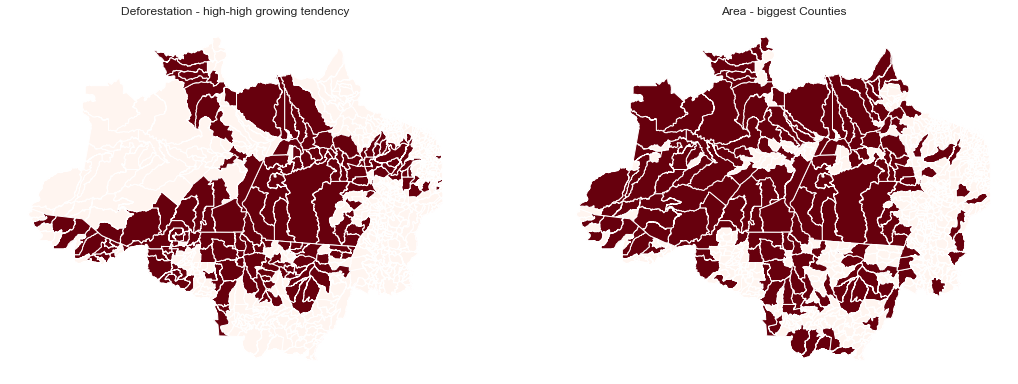

In [206]:
#Comparison - high-high classification
fig, (ax1, ax2)= plt.subplots(1,2)

high_countie_map_def.plot(column='def_acc_quartile', cmap='Reds', ax=ax1) 
ax1.axis('off')
ax1.set_title('Deforestation - high-high growing tendency') 

high_countie_map_area = area_map.copy()
high_countie_map_area['area_slope_quartile'] = high_countie_map_area['area_slope_quartile'].apply(lambda x: 'high-high' if x=='high-high' else '-')
high_countie_map_area.fillna(0, inplace=True)
high_countie_map_area.plot(column='area_slope_quartile', cmap='Reds', ax=ax2) 
ax2.axis('off')
ax2.set_title('Area - biggest Counties') ;

In [207]:
#Select only high-high agriculture slope

high_area = area_quarter[area_quarter['area_slope_quartile'] == 'high-high']

size_area = len(high_area)
size_area

155

In [208]:
#Inner join to see Counties in common

shared_def_area = high_def.merge(high_area, on='cod_ibge', how='inner')

size_shared_def_area = len(shared_def_area) 

(size_shared_def_area / size_area) * 100

53.5483870967742

In [209]:
#Merge with counties map database

shared_map_def_area = mun.merge(shared_def_area, on='cod_ibge', how='left')
shared_map_def_area.fillna('-', inplace=True)

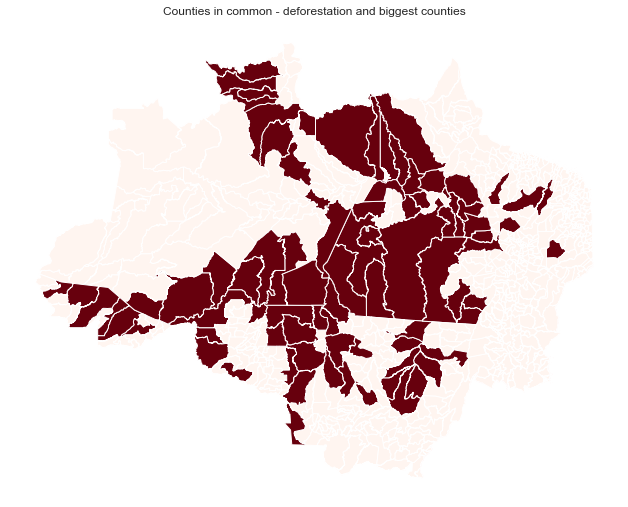

In [210]:
#Visualize result

shared_map_def_area.plot(column='area_slope_quartile', cmap='Reds', figsize=(11,11)).set_title('Counties in common - deforestation and biggest counties')
plt.axis('off') ;

#### **H11.** **More** than **1/4 of Counties** classified as **high-high** in **population** and **cumulative deforestation** are shared

**FALSE**: population and cumulative deforestation share nearly **~39% of Counties** 

In [211]:
#Calculate quarters
pop_quarter = df_countie[['population']]

pop_quarter['pop_quartile'] = 0
pop_quarter.sort_values(by='population', ascending=False, inplace=True)
pop_quarter['pop_quartile'] = pd.qcut(pop_quarter['population'], q=5, duplicates='drop')

In [212]:
#Remove special characters

pop_quarter['pop_quartile'] = pop_quarter['pop_quartile'].astype('str')
pop_quarter['pop_quartile'] = pop_quarter['pop_quartile'].str.replace('(','')
pop_quarter['pop_quartile'] = pop_quarter['pop_quartile'].str.replace(']','')

In [213]:
pop_quarter['pop_quartile'].unique()

array(['36164.6, 2219580.0', '19944.2, 36164.6', '11927.2, 19944.2',
       '6139.6, 11927.2', '945.999, 6139.6'], dtype=object)

In [214]:
#Replace for classification

class_dict = {'36164.6, 2219580.0':'high-high','19944.2, 36164.6':'low-high','11927.2, 19944.2':'high-low','6139.6, 11927.2':'low-low','945.999, 6139.6':'zero (very low)'}           

pop_quarter['pop_quartile'] = pop_quarter['pop_quartile'].map(class_dict)

In [215]:
#See distribution

pop_quarter['pop_quartile'].value_counts(normalize=True)*100

zero (very low)    20.077720
high-high          20.077720
low-high           19.948187
high-low           19.948187
low-low            19.948187
Name: pop_quartile, dtype: float64

In [216]:
#Transform index

pop_quarter.reset_index(inplace=True)
pop_quarter['cod_ibge'] = pop_quarter['cod_ibge'].astype('int')

In [217]:
#Merge with counties map database

pop_map = mun.merge(pop_quarter, on='cod_ibge', how='left')

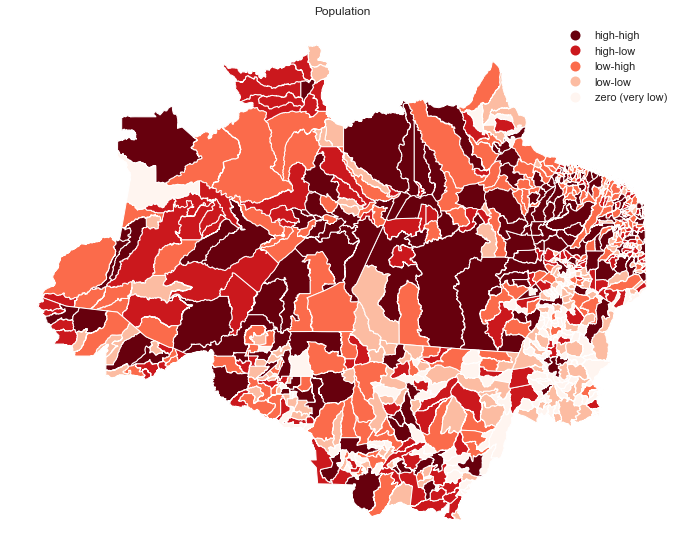

In [218]:
#Plot Population density

pop_map.plot(column='pop_quartile', cmap='Reds_r', figsize=(12,12), legend=True).set_title('Population') 
plt.axis('off') ;

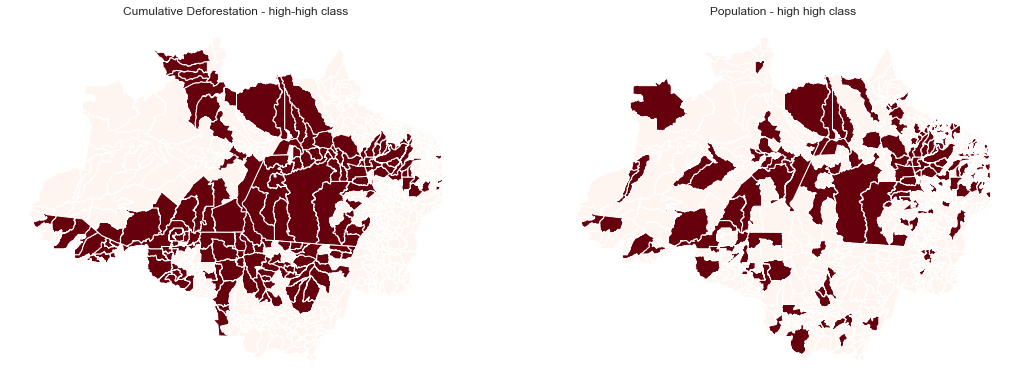

In [219]:
#Comparison - high-high classification
fig, (ax1, ax2)= plt.subplots(1,2)

high_countie_map_def.plot(column='def_acc_quartile', cmap='Reds', ax=ax1) 
ax1.axis('off')
ax1.set_title('Cumulative Deforestation - high-high class') 

high_countie_map_pop = pop_map.copy()
high_countie_map_pop['pop_quartile'] = high_countie_map_pop['pop_quartile'].apply(lambda x: 'high-high' if x=='high-high' else '-')
high_countie_map_pop.fillna(0, inplace=True)
high_countie_map_pop.plot(column='pop_quartile', cmap='Reds', ax=ax2) 
ax2.axis('off')
ax2.set_title('Population - high high class') ;

In [220]:
#Select only high-high agriculture slope

high_pop = pop_quarter[pop_quarter['pop_quartile'] == 'high-high']

size_pop = len(high_pop)
size_pop

155

In [221]:
#Inner join to see Counties in common

shared_def_pop = high_def.merge(high_pop, on='cod_ibge', how='inner')

size_shared_def_pop = len(shared_def_pop) 

(size_shared_def_pop / size_pop) * 100

38.70967741935484

In [222]:
#Merge with counties map database

shared_map_def_pop = mun.merge(shared_def_pop, on='cod_ibge', how='left')
shared_map_def_pop.fillna('-', inplace=True)

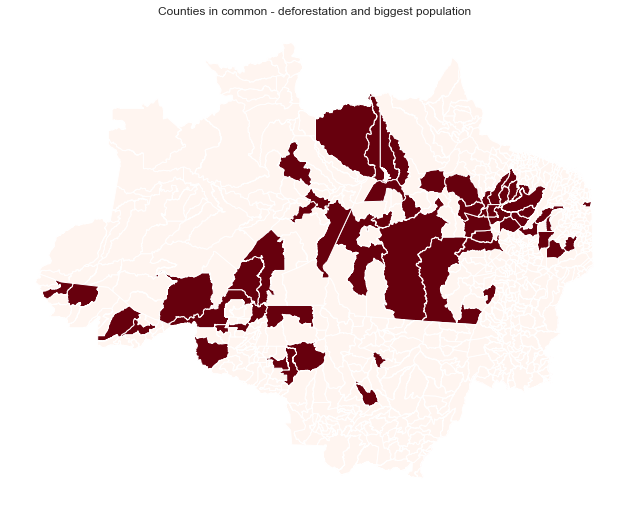

In [223]:
#Visualize result

shared_map_def_pop.plot(column='pop_quartile', cmap='Reds', figsize=(11,11)).set_title('Counties in common - deforestation and biggest population')
plt.axis('off') ;

# 6.0 Machine Learning Modelling

Since we are **interested** in the Counties **cumulative deforestation high-high class**, this class is going to be the **True class (or 1)** and all the other classes is going to be turned into **False (or 0)**. The **goal** of the Machine Learning modelling **is to bring light** to **which features** different algorithms consider **more important** to predict **high-high cumulative deforestation**

Therefore, the attention will be directed towards these **three categories** of data: **Rural Industry** (agriculture and cattle); **Social & Economic** (GDP and HDIs) and **Legal protected areas** (deforestation in indigenous areas). The category of inherent general **Characteristics** such as area and population **will not be considered**

## 6.1 Create DataFrame

Selecting only **features that will be used in the analysis**

In [275]:
#Create new DataFrame

df = df_countie.copy() 
df.reset_index(inplace=True)
df['cod_ibge'] = df['cod_ibge'].astype('int')

In [276]:
#Select feature classification

def_class = def_acc_countie_quarter[['cod_ibge', 'def_acc_quartile']]

agri_class = agri_acc[['cod_ibge', 'agri_acc_quartile']]

cattle_class = cattle_acc[['cod_ibge', 'cattle_acc_quartile']]

gdp_class = gdp_quarter[['cod_ibge', 'gdp_acc_quartile']]

ind_class = ind_not_zero[['cod_ibge', 'ind_class']]

In [277]:
#Merge DataFrames

df = df.merge(def_class, on='cod_ibge', how='left')

df = df.merge(agri_class, on='cod_ibge', how='left')

df = df.merge(cattle_class, on='cod_ibge', how='left')

df = df.merge(gdp_class, on='cod_ibge', how='left')

df = df.merge(ind_class, on='cod_ibge', how='left')

In [278]:
#Fill NaNs of indigenous areas

df['ind_class'] = df['ind_class'].fillna('zero')

In [279]:
#Rename columns

df.columns = ['cod_ibge', 'def_acc', 'agri_acc', 'cattle_acc', 'gdp_acc', 'ind_acc', 'area_countie', 'population', 'IDHM', 'IDHM_renda', 'IDHM_educacao', 'IDHM_longevidade', 'def_class', 'agri_class', 'cattle_class', 'gdp_class', 'ind_class']                                            


In [280]:
#Remove identification and Cumulative Deforestation column

df.drop(['cod_ibge', 'def_acc', 'ind_acc', 'area_countie', 'population'], axis=1, inplace=True)

## 6.2 Encoding

Encoding **categorical variables into numbers** to fit into the algorithms and **transform the class high-high class to True (or 1)** and the rest into **False (or 0)** 

In [281]:
#Create dictionaries 

dict1 = {'high-high':1,'high-low':0,'low-high':0,'low-low':0,'zero':0}

dict2 = {'high-high':4,'high-low':3,'low-high':2,'low-low':1,'zero (very low)':0}

dict3 = {'ind_deforestation':1,'zero':0}

In [282]:
#Map 

df['def_class'] = df['def_class'].map(dict1)
df['agri_class'] = df['agri_class'].map(dict2)
df['cattle_class'] = df['cattle_class'].map(dict2)
df['gdp_class'] = df['gdp_class'].map(dict2)
df['ind_class'] = df['ind_class'].map(dict3)

## 6.3 Balance and split data

Since the **high-high cumulative deforestation class accounts only for ~20% of the data** and is the class we are interested in, it is interesting to **rebalance the data with a statistical boostrap tool** — SMOTE Tomek — so the Machine Learning algorithms **learn to predict both classes equally**

In [405]:
#Split into training and test data

X = df.drop('def_class', axis=1)
y = df['def_class']

X_train_imb, X_test, y_train_imb, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

In [406]:
#Balance dataset
resampler = SMOTETomek(random_state=123, n_jobs=-1)

X_train, y_train = resampler.fit_resample(X_train_imb, y_train_imb)

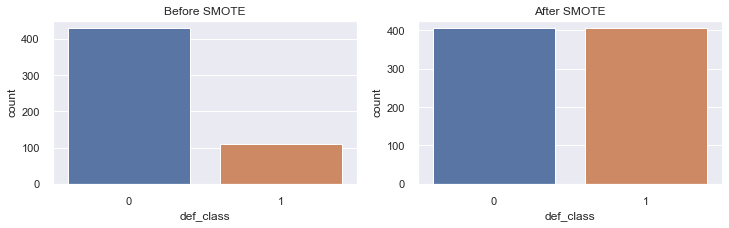

In [407]:
#Plot Before and after
plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
sns.countplot(x=y_train_imb).set_title('Before SMOTE')

plt.subplot(1,2,2)
sns.countplot(x=y_train).set_title('After SMOTE') ;

## 6.4 Fit data into the algoritms 

The type of **Machine Learning** algorithm used here is **Classification** since we are predicting the **high-high cumulative deforestation class**. Specifically, we'll use this four algorithms:

**Random Forest**: it is a **tree based model** built with **multiple ensamble decision trees** created with the **bagging method**. Then, all the classifiers take a **weighted vote on their predictions**. Since the algorithm goal **is not trying to find a linear function** to describe the event, it **works for problems with more complex behaviour**

**Extremely Randomized Trees**: it works on the **same logic of Random Forest**, but instead of using multiple ensamble bootstrap replicas, **it uses the original sample**. The randomization is added on the **cut point to splitting the tree nodes**, while the **previous algorithm chooses the best optimum split**, the Extremely Randomized Trees **chooses it randomly**

**XGBoost**: it is also a **tree based model** but they are **built in a different way**. While Random Forests builds each tree independently, **XGBoost builds one tree at the time learning with its predecessor**. Therefore, this algorithm **doesn't combine results at the end** of the process by taking majority votes, it **combines the results along the way**

**CatBoost**: this model share the **same logic of XGBoost**, however the **focus is in optimizing the decision trees for categorical variables**. The goal is to work better with features with classes that **have relation with one another like, for example, different colors**  

In [408]:
#Random Forest 

rf = RandomForestClassifier(n_estimators=5000, random_state=123)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5000, random_state=123)

In [409]:
#Random Forest 

ext = ExtraTreesClassifier(n_estimators=5000, random_state=123)

ext.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=5000, random_state=123)

In [410]:
#XGBoost

xgb = XGBClassifier(n_estimators=5000, random_state=123, n_jobs=-1, eval_metric='logloss')

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=5000, n_jobs=-1,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [411]:
#CatBoost

categories = ['agri_class', 'cattle_class', 'gdp_class', 'ind_class']               

params = {'iterations':5000, 'random_seed':123, 'cat_features':categories, 'eval_metric':'BalancedAccuracy', 'verbose':False}

cat_boost = CatBoostClassifier(**params)

cat_boost.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, plot=False)

## 6.5 Performance comparison

It is **relevant to know** which of the Machine Learning model is performing better **because in case they have different features importances**, we know **where to give more attention**, even tough **performance it's not the focus here**

**Conclusion**: we will consider here that all algorithms **performed virtually the same except CatBoost** that had a **lower efficiency**. Therefore, CatBoost **is not going to be part of the feature importance analysis**

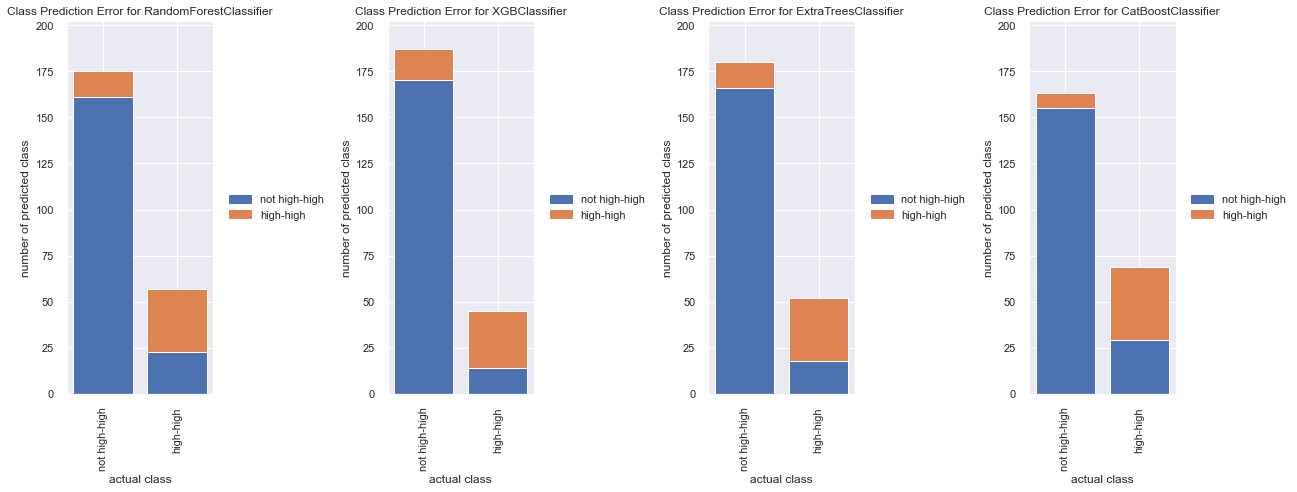

In [427]:
#Plot Class prediction graph
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4,figsize=(20, 7))

visualizer = ClassPredictionError(rf, classes=['not high-high', 'high-high'], ax=ax1)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.finalize()

visualizer = ClassPredictionError(xgb, classes=['not high-high', 'high-high'], ax=ax2)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
g = visualizer.finalize()

visualizer = ClassPredictionError(wrap(ext), classes=['not high-high', 'high-high'], ax=ax3)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
g = visualizer.finalize()

visualizer = ClassPredictionError(wrap(cat_boost), classes=['not high-high', 'high-high'], ax=ax4)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
g = visualizer.finalize()

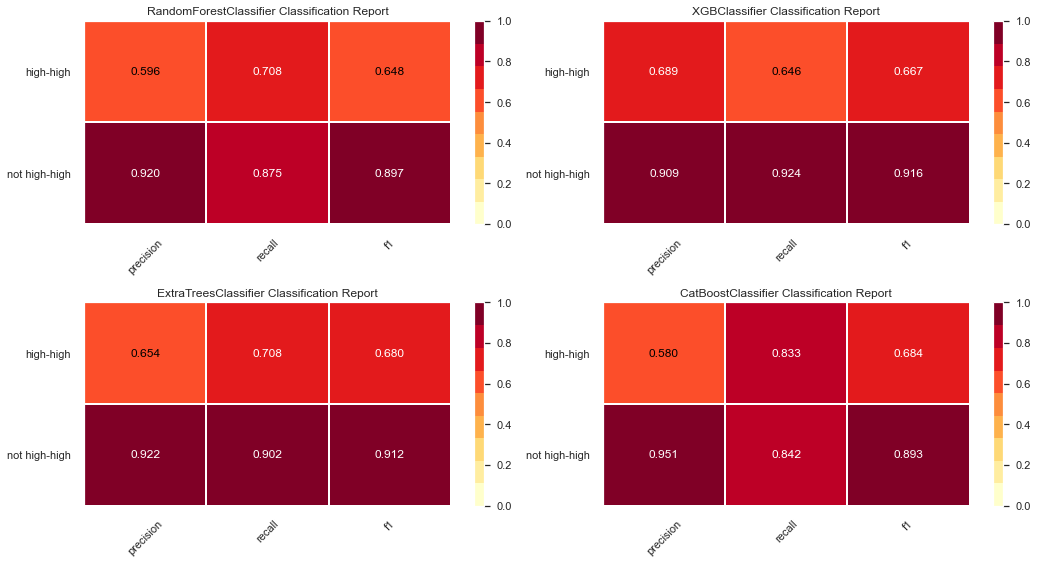

In [428]:
#Classification report
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15, 8))

visualizer = ClassificationReport(rf, support=False, classes=['not high-high', 'high-high'], ax=ax1)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.finalize()

visualizer = ClassificationReport(xgb, support=False, classes=['not high-high', 'high-high'], ax=ax2)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.finalize()

visualizer = ClassificationReport(ext, support=False, classes=['not high-high', 'high-high'], ax=ax3)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.finalize()

visualizer = ClassificationReport(wrap(cat_boost), classes=['not high-high', 'high-high'], support=False, ax=ax4)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.finalize()

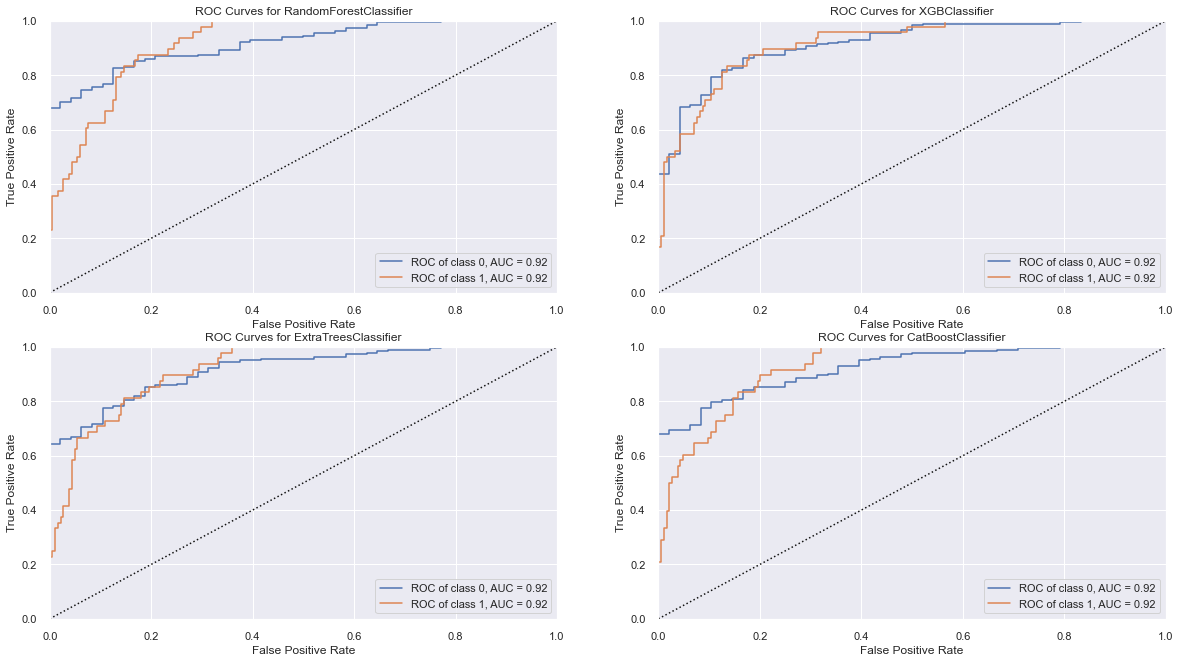

In [429]:
#ROC AUC ccurve
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 11))

viz = ROCAUC(rf, iso_f1_curves=True, micro=False, macro=False, ax=ax1)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

viz = ROCAUC(xgb, iso_f1_curves=True, micro=False, macro=False, ax=ax2)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

viz = ROCAUC(ext, iso_f1_curves=True, micro=False, macro=False, ax=ax3)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

viz = ROCAUC(wrap(cat_boost), iso_f1_curves=True, micro=False, macro=False, ax=ax4)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

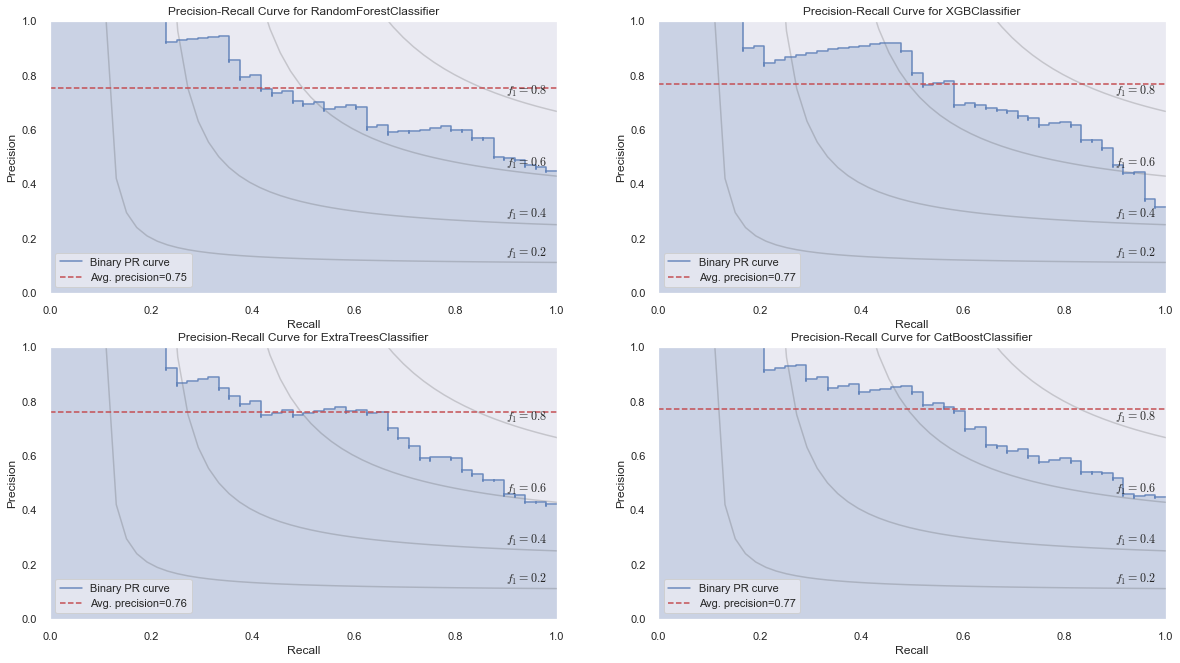

In [430]:
#Precision-recall ccurve
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 11))

viz = PrecisionRecallCurve(rf, iso_f1_curves=True, ax=ax1)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

viz = PrecisionRecallCurve(xgb, iso_f1_curves=True, ax=ax2)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

viz = PrecisionRecallCurve(ext, iso_f1_curves=True, ax=ax3)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

viz = PrecisionRecallCurve(wrap(cat_boost), iso_f1_curves=True, ax=ax4)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

In [420]:
#Cross validation - Balanced Accuracy

cv = StratifiedKFold(n_splits=12, random_state=123, shuffle=True)
score_rf = cross_val_score(rf, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
score_rf = pd.DataFrame(score_rf)

score_ext = cross_val_score(ext, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
score_ext = pd.DataFrame(score_ext)

score_xgb = cross_val_score(xgb, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
score_xgb = pd.DataFrame(score_xgb)

score_cat = cross_val_score(cat_boost, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
score_cat = pd.DataFrame(score_cat)

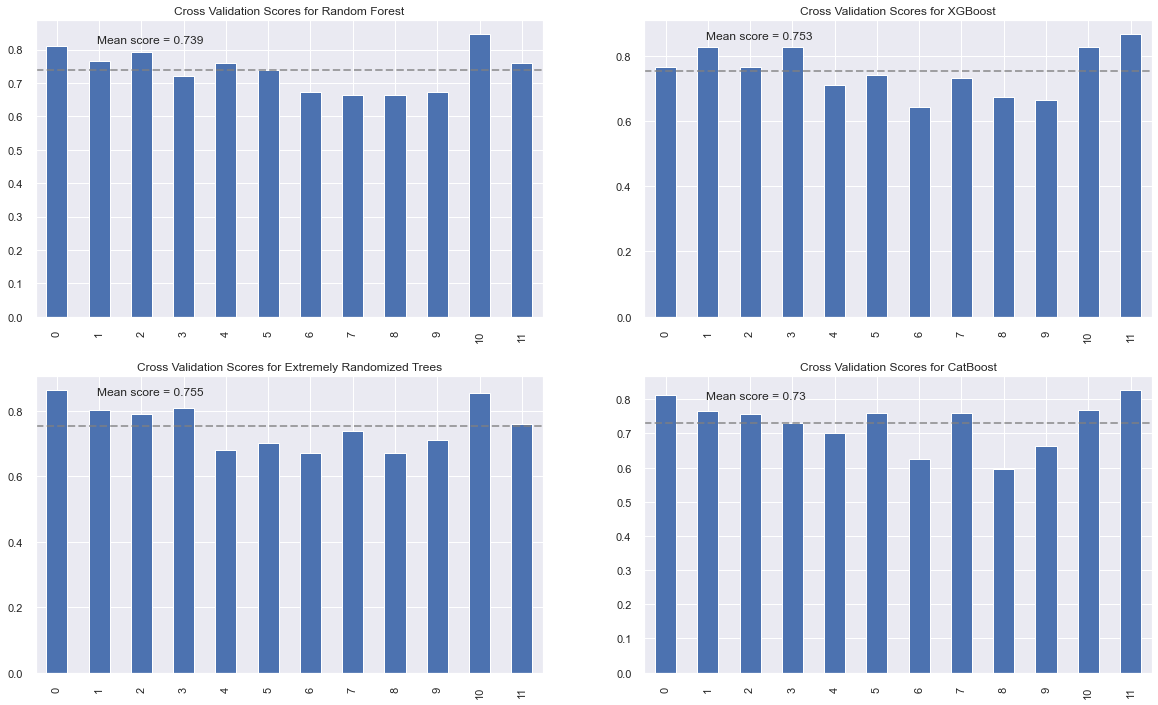

In [431]:
#Plot CV - Balanced Accuracy
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 12))

y_rf = float(score_rf.mean().round(3))
score_rf.plot(kind='bar', legend=False, ax=ax1) 
ax1.axhline(y=y_rf, color='gray', linewidth=2, alpha=.7, ls='--')
ax1.text(0.95,0.82, 'Mean score = {}'.format(y_rf)) 
ax1.set_title('Cross Validation Scores for Random Forest')

y_xgb = float(score_xgb.mean().round(3))
score_xgb.plot(kind='bar', legend=False, ax=ax2) 
ax2.axhline(y=y_xgb, color='gray', linewidth=2, alpha=.7, ls='--')
ax2.text(0.95,0.85, 'Mean score = {}'.format(y_xgb)) 
ax2.set_title('Cross Validation Scores for XGBoost')

y_ext = float(score_ext.mean().round(3))
score_ext.plot(kind='bar', legend=False, ax=ax3) 
ax3.axhline(y=y_ext, color='gray', linewidth=2, alpha=.7, ls='--')
ax3.text(0.95,0.85, 'Mean score = {}'.format(y_ext)) 
ax3.set_title('Cross Validation Scores for Extremely Randomized Trees')

y_cat = float(score_cat.mean().round(3))
score_cat.plot(kind='bar', legend=False, ax=ax4) 
ax4.axhline(y=y_cat, color='gray', linewidth=2, alpha=.7, ls='--')
ax4.text(0.95,0.80, 'Mean score = {}'.format(y_cat)) 
ax4.set_title('Cross Validation Scores for CatBoost') ;

## 6.6 Feature importance

For this study, this is the **most meaningful analysis** since our **goal is to show which features** the Machine Learning algorithms are considering **more important for predicting the high-high cumulative deforestation class**

In [294]:
#Instantiate SHAP 

shap.initjs()

### 6.6.1 Random Forest

This algorithm considered more important to predicting deforestation: **1º cumulative cattle** with positive correlation, **2º cumulative gdp** with positive correlation, **3º cumulative agriculture** with positive correlation and **4º Education HDI** with negative correlation

In [418]:
#SHAP explainer - Random Forest

explainer_random = shap.TreeExplainer(rf)

shap_values_rf = explainer_random.shap_values(X_train)

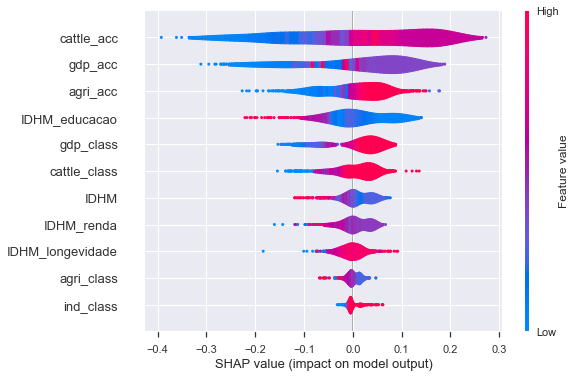

In [419]:
shap.summary_plot(shap_values_rf[1], X_train, plot_type="violin")

### 6.6.2 XGBoost

This algorithm considered more important to predicting deforestation: **1º cumulative cattle** with positive correlation, **2º Education HDI** with negative correlation, **3º cumulative gdp** with positive correlation and **4º cumulative agriculture** with negative correlation

In [422]:
#SHAP explainer - XGBoost

explainer_random = shap.TreeExplainer(xgb)

shap_values_xgb = explainer_random.shap_values(X_train)

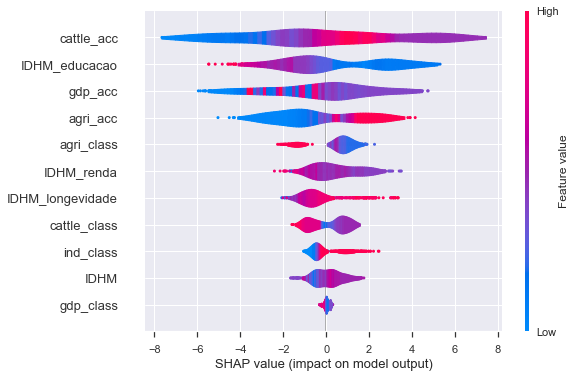

In [426]:
shap.summary_plot(shap_values_xgb, X_train, plot_type='violin')

### 6.6.3 Extremely Randomized Trees

This algorithm considered more important to predicting deforestation: **1º gdp classification ranking** with positive correlation, **2º cattle classification ranking** with positive correlation, **3º cumulative cattle** with positive correlation and **4º Education HDI** with negative correlation

In [416]:
#SHAP explainer - Extremely Randomized Trees

explainer_random = shap.TreeExplainer(ext)

shap_values_ext = explainer_random.shap_values(X_train)

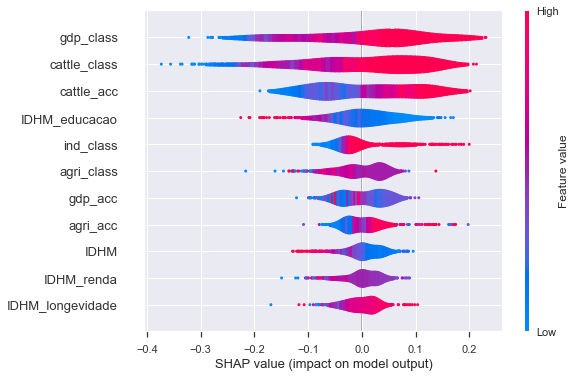

In [417]:
shap.summary_plot(shap_values_ext[1], X_train, plot_type='violin')

### 6.6.4 Conclusion

In conformity with the previous correlation analysis, **Cattle farming is, overall, the most predicting feature for cumulative deforestation in this period of time**

**GDP** of the counties is the second factor that the algorithms **considered relevant** for predicting high-high deforestation class

In third place, **Education Human Development Index** reveled an interesting **negative correlation** with counties that had the **biggest deforestation** areas during this time 

The fourth place is **Agriculture** that also exhibited a **positive correlation** with counties with greater deforestation; however, this relathionship **is not as significant** as the **Cattle farming**  

It is also worth mentioning that **even though it's not as relevant for prediction**, counties that have **deforestation in indigenous areas**, classification equals to True or 1, demonstrated a **positive correlation with high-high deforestation**